# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in two ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.

* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
import contextlib
import dataclasses
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import qutip
from qutip import (
    basis,
    expect,
    liouvillian,
    sigmax,
    sigmaz,
    spost,
    spre,
)
from qutip.solver.heom import (
    HEOMSolver,
    BosonicBath,
)

# Import mpmath functions for evaluation of gamma and zeta
# functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

%matplotlib inline

## Helper functions

Let's define some helper functions for plotting results and timing how long operations take:

In [2]:
def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

In [3]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of (solver_result,
        measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == 'rand':
            axes.plot(
                result.times, exp,
                c=np.random.rand(3,), label=label, **kw,
            )
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [4]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [5]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [6]:
# Defining the system Hamiltonian
eps = 0.0    # Energy of the 2-level system.
Del = 0.2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [7]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [8]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59, but with a factor of $\pi$ moved into the definition of the correlation function):

\begin{align}
C(t) =& \: \frac{1}{\pi}\alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [9]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [10]:
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [11]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w
        (and the bath parameters).
    """
    return (
        w * alpha * np.e**(-abs(w) / wc) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [12]:
# Bath parameters:

@dataclasses.dataclass
class OhmicBathParameters:
    """ Ohmic bath parameters. """
    Q: object = dataclasses.field(default_factory=sigmaz, repr=False)
    alpha: float = 3.25
    T: float = 0.5
    wc: float = 1.0
    s: float = 1

    def __post_init__(self):
        self.beta = 1 / self.T

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


obp = OhmicBathParameters()

And set the cut-off for the HEOM hierarchy:

In [13]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5

## Building the HEOM bath by fitting the spectral density

We begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form (J. Chem. Phys. 111, 3365 (1999); https://doi.org/10.1063/1.479669):

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

In [14]:
# Helper functions for packing the paramters a, b and c into a single numpy
# array as required by SciPy's curve_fit:

def pack(a, b, c):
    """ Pack parameter lists for fitting. """
    return np.concatenate((a, b, c))


def unpack(params):
    """ Unpack parameter lists for fitting. """
    N = len(params) // 3
    a = np.array(params[:N])
    b = np.array(params[N:2 * N])
    c = np.array(params[2 * N:])
    return a, b, c

In [15]:
# The approximate spectral density and a helper for fitting the approximate
# spectral density to values calculated from the analytical formula:

def spectral_density_approx(w, a, b, c):
    """ Calculate the fitted value of the function for the given
        parameters.
    """
    return np.sum(
        2 * a[:, None] * np.multiply.outer(b, w) / (
            ((w + c[:, None])**2 + b[:, None]**2) *
            ((w - c[:, None])**2 + b[:, None]**2)
        ),
        axis=0,
    )


def fit_spectral_density(J, w, alpha, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.0001] * len(w)

    J_max = abs(max(J, key=abs))

    guesses = pack([J_max] * N, [wc] * N, [wc] * N)
    lower_bounds = pack([-100 * J_max] * N, [0.1 * wc] * N, [0.1 * wc] * N)
    upper_bounds = pack([100 * J_max] * N, [100 * wc] * N, [100 * wc] * N)

    params, _ = curve_fit(
        lambda x, *params: spectral_density_approx(w, *unpack(params)),
        w, J,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)

With the spectral density approximation $J_{\mathrm approx}(w; a, b, c)$ implemented above, we can now perform the fit and examine the results.

In [16]:
w = np.linspace(0, 25, 20000)
J = ohmic_spectral_density(w, alpha=obp.alpha, wc=obp.wc)

params_k = [
    fit_spectral_density(J, w, alpha=obp.alpha, wc=obp.wc, N=i+1)
    for i in range(4)
]

Let's plot the fit for each $k$ and examine how it improves with an increasing number of terms:

Parameters [k=0]: lam=[6.14746382]; gamma=[1.77939431]; w0=[0.1]


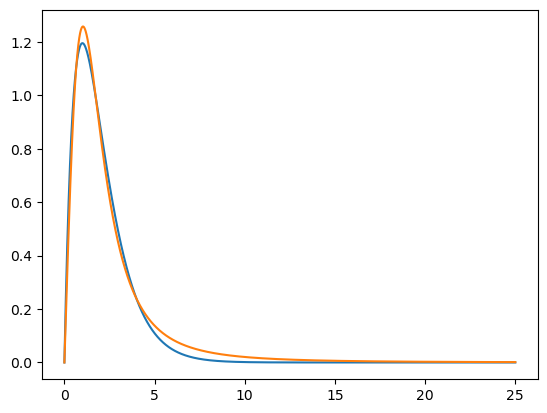

Parameters [k=1]: lam=[3.26249548 2.2118894 ]; gamma=[1.43449472 1.24955712]; w0=[1.80554824 0.1       ]


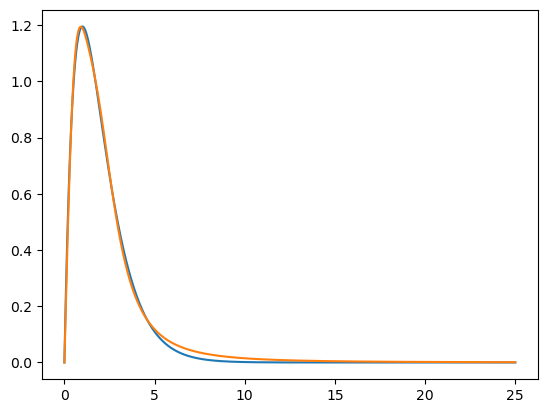

Parameters [k=2]: lam=[1.12689181 2.33978096 1.65007407]; gamma=[1.00851471 1.0936228  1.18462034]; w0=[0.13355831 1.37012837 2.69761285]


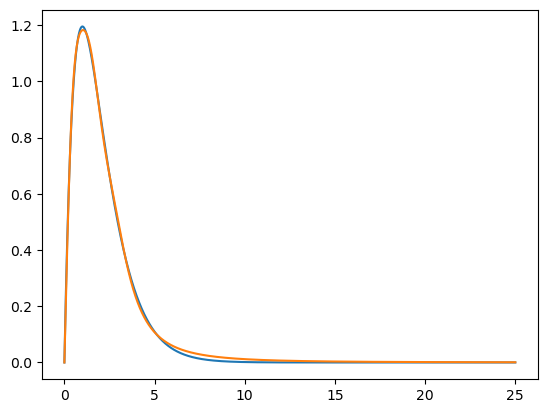

Parameters [k=3]: lam=[ 7.9159269   0.60083713 -4.40789259  0.01058514]; gamma=[2.29618997 1.00246805 4.29908162 0.30736325]; w0=[0.1        0.1        3.98168657 0.1       ]


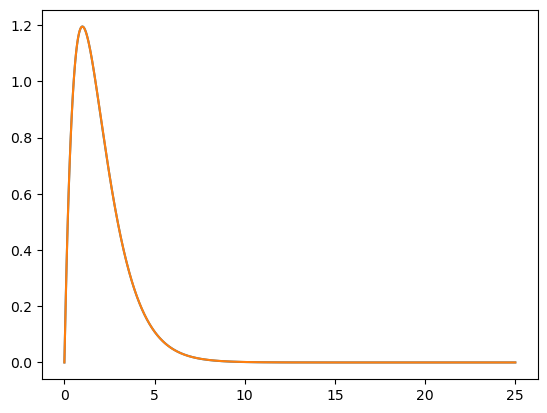

In [17]:
for k, params in enumerate(params_k):
    lam, gamma, w0 = params
    y = spectral_density_approx(w, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(w, J, w, y)
    plt.show()

The fit with four terms looks good. Let's take a closer look at it by plotting the contribution of each term of the fit:

In [18]:
# The parameters for the fit with four terms:

lam, gamma, w0 = params_k[-1]

print(f"Parameters [k={len(params_k) - 1}]: lam={lam}; gamma={gamma}; w0={w0}")

Parameters [k=3]: lam=[ 7.9159269   0.60083713 -4.40789259  0.01058514]; gamma=[2.29618997 1.00246805 4.29908162 0.30736325]; w0=[0.1        0.1        3.98168657 0.1       ]


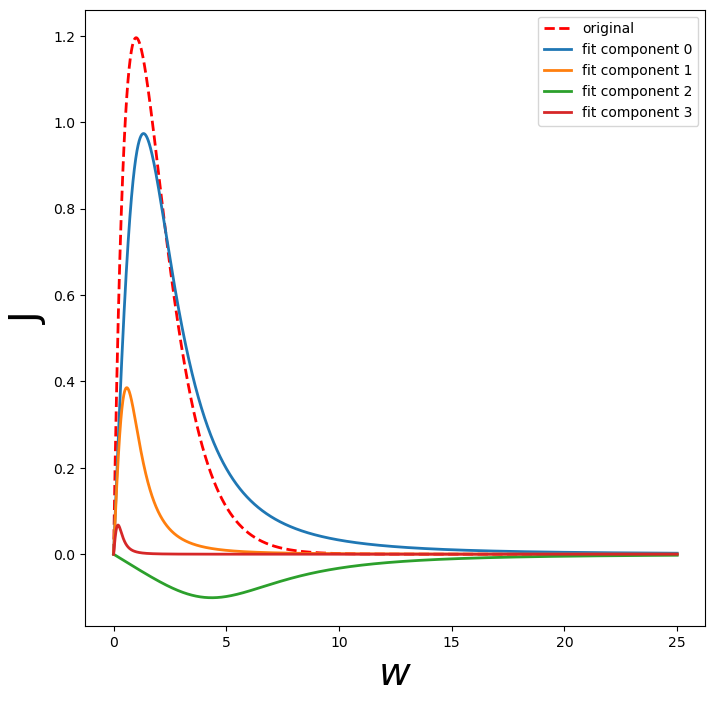

In [19]:
# Plot the components of the fit separately:

def spectral_density_ith_component(w, i, lam, gamma, w0):
    """ Return the i'th term of the approximation for the spectral density. """
    return (
        2 * lam[i] * gamma[i] * w /
        (((w + w0[i])**2 + gamma[i]**2) * ((w - w0[i])**2 + gamma[i]**2))
    )


def plot_spectral_density_fit_components(J, w, lam, gamma, w0):
    """ Plot the individual components of a fit to the spectral density. """
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, J, 'r--', linewidth=2, label="original")
    for i in range(len(lam)):
        axes.plot(
            w, spectral_density_ith_component(w, i, lam, gamma, w0),
            linewidth=2,
            label=f"fit component {i}",
        )

    axes.set_xlabel(r'$w$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)
    axes.legend()

    return fig


plot_spectral_density_fit_components(J, w, lam, gamma, w0);

And let's also compare the power spectrum of the fit and the analytical spectral density:

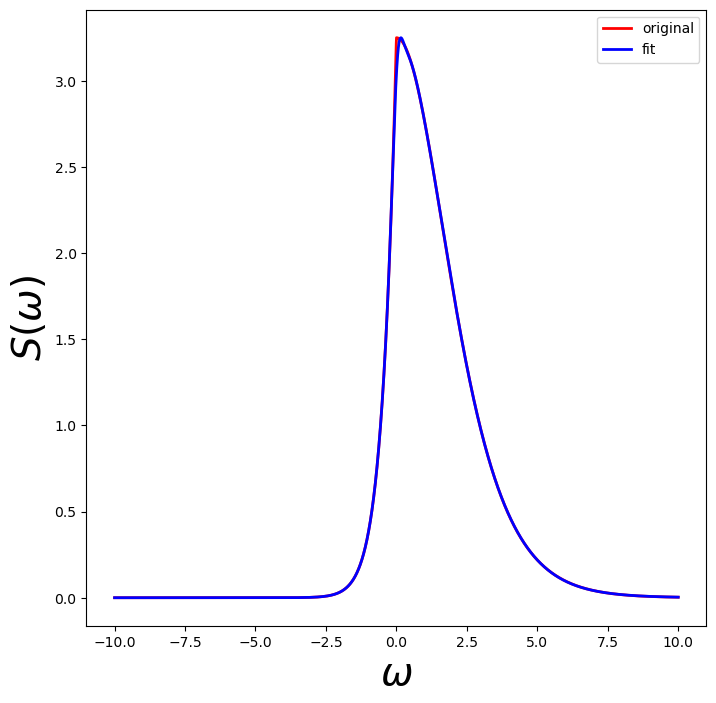

In [20]:
def plot_power_spectrum(alpha, wc, beta, lam, gamma, w0, save=True):
    """ Plot the power spectrum of a fit against the actual power spectrum. """
    w = np.linspace(-10, 10, 50000)

    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = (
        spectral_density_approx(w, lam, gamma, w0) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, s_orig, 'r', linewidth=2, label="original")
    axes.plot(w, s_fit, 'b', linewidth=2, label="fit")

    axes.set_xlabel(r'$\omega$', fontsize=28)
    axes.set_ylabel(r'$S(\omega)$', fontsize=28)
    axes.legend()

    if save:
        fig.savefig('powerspectrum.eps')


plot_power_spectrum(obp.alpha, obp.wc, obp.beta, lam, gamma, w0, save=False)

Now that we have a good fit to the spectral density, we can calculate the Matsubara expansion terms for the `BosonicBath` from them. At the same time we will calculate the Matsubara terminator for this expansion.

In [21]:
def matsubara_coefficients_from_spectral_fit(lam, gamma, w0, beta, Q, Nk):
    """ Calculate the Matsubara co-efficients for a fit to the spectral
        density.
    """
    # initial 0 value with the correct dimensions:
    terminator = 0. * spre(Q)
    # the number of matsubara expansion terms to include in the terminator:
    terminator_max_k = 1000

    ckAR = []
    vkAR = []
    ckAI = []
    vkAI = []

    for lamt, Gamma, Om in zip(lam, gamma, w0):

        ckAR.extend([
            (lamt / (4 * Om)) * coth(beta * (Om + 1.0j * Gamma) / 2),
            (lamt / (4 * Om)) * coth(beta * (Om - 1.0j * Gamma) / 2),
        ])
        for k in range(1, Nk + 1):
            ek = 2 * np.pi * k / beta
            ckAR.append(
                (-2 * lamt * 2 * Gamma / beta) * ek /
                (
                    ((Om + 1.0j * Gamma)**2 + ek**2) *
                    ((Om - 1.0j * Gamma)**2 + ek**2)
                )
            )

        terminator_factor = 0
        for k in range(Nk + 1, terminator_max_k):
            ek = 2 * np.pi * k / beta
            ck = (
                (-2 * lamt * 2 * Gamma / beta) * ek /
                (
                    ((Om + 1.0j * Gamma)**2 + ek**2) *
                    ((Om - 1.0j * Gamma)**2 + ek**2)
                )
            )
            terminator_factor += ck / ek
        terminator += terminator_factor * (
            2 * spre(Q) * spost(Q.dag())
            - spre(Q.dag() * Q)
            - spost(Q.dag() * Q)
        )

        vkAR.extend([
            -1.0j * Om + Gamma,
            1.0j * Om + Gamma,
        ])
        vkAR.extend([
            2 * np.pi * k * obp.T + 0.j
            for k in range(1, Nk + 1)
        ])

        ckAI.extend([
            -0.25 * lamt * 1.0j / Om,
            0.25 * lamt * 1.0j / Om,
        ])
        vkAI.extend([
            -(-1.0j * Om - Gamma),
            -(1.0j * Om - Gamma),
        ])

    return ckAR, vkAR, ckAI, vkAI, terminator

In [22]:
def generate_spectrum_results(obp, params, Nk, max_depth):
    """ Run the HEOM with the given bath parameters and
        and return the results of the evolution.
    """
    lam, gamma, w0 = params
    ckAR, vkAR, ckAI, vkAI, terminator = (
        matsubara_coefficients_from_spectral_fit(
            lam, gamma, w0, beta=obp.beta, Q=obp.Q, Nk=Nk,
        )
    )
    Ltot = liouvillian(Hsys) + terminator
    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    with timer("RHS construction time"):
        bath = BosonicBath(obp.Q, ckAR, vkAR, ckAI, vkAI)
        HEOM_spectral_fit = HEOMSolver(
            Ltot, bath, max_depth=max_depth, options=options,
        )

    with timer("ODE solver time"):
        results_spectral_fit = (HEOM_spectral_fit.run(rho0, tlist))

    return results_spectral_fit

Below we generate results for different convergence parameters (number of terms in the fit, number of matsubara terms, and depth of the hierarchy).  For the parameter choices here, we need a relatively large depth of around '11', which can be a little slow.

RHS construction time: 0.009895086288452148
 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.87s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.87s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.87s / Remaining 00:00:00:00

 Total run time:   0.87s
ODE solver time: 0.8693947792053223


RHS construction time: 0.046163082122802734

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.10s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.55s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.55s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.56s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.59s / Remaining 00:00:00:00

 Total run time:   1.59s
ODE solver time: 1.5882220268249512


RHS construction time: 0.1588294506072998

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.11s / Remaining 00:00:00:10

 [          1%           ] Elapsed 0.12s / Remaining 00:00:00:12

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:16

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:17

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.20s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.21s / Remaining 00:00:00:10

 [          2%           ] Elapsed 0.21s / Remaining 00:00:00:10

 [          2%           ] Elapsed 0.22s / Remaining 00:00:00:10

 [*         3%           ] Elapsed 0.23s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.23s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.24s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.25s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.26s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.26s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.27s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.28s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.28s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.29s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.30s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.30s / Remaining 00:00:00:07

 [*         5%           ] Elapsed 0.31s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.32s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.32s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.33s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.34s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.34s / Remaining 00:00:00:06

 [*         6%           ] Elapsed 0.35s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.36s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.37s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.37s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.38s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.39s / Remaining 00:00:00:06

 [**        7%           ] Elapsed 0.39s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.40s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.41s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.41s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.42s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.43s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.43s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.44s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.45s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.46s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.46s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.47s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.48s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.49s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.50s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.50s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.51s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.52s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.53s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.54s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.54s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.55s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.56s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.56s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.57s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.58s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.59s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.59s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.60s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.61s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.62s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.63s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.63s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.64s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.65s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.66s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.66s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.67s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.68s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.69s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.70s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.70s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.71s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.72s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.73s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.73s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.74s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.75s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.76s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.76s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.77s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.78s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.79s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.80s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.80s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.81s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.82s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.82s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.83s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.84s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.85s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.85s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.86s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.87s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.87s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.88s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.89s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.90s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.90s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.91s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 0.93s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.94s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.94s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 0.95s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 0.97s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.98s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.98s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.99s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 1.00s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.01s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 1.02s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 1.03s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 1.03s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 1.04s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 1.05s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.06s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.07s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.07s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.08s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.09s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 1.10s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.10s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.11s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.12s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.13s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 1.14s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.15s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.15s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.16s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.17s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.18s / Remaining 00:00:00:03

 [******   24%           ] Elapsed 1.18s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.19s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.20s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.21s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.22s / Remaining 00:00:00:03

 [******   25%           ] Elapsed 1.22s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.23s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.24s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.25s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   26%           ] Elapsed 1.26s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.27s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.28s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.29s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.29s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.30s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.31s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.32s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.33s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.34s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.35s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.36s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.37s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.38s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.39s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.40s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.41s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.42s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.42s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.43s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.44s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.44s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.45s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.46s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.47s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.48s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.49s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.49s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.50s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.51s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.52s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.53s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.53s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.54s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.55s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.56s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.56s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.57s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.58s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.59s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.60s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.60s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.61s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.62s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.62s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.63s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.64s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.65s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.65s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.66s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.67s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.67s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.68s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.69s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.70s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.70s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.71s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.72s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.73s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 1.73s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.74s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.75s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.76s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.77s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 1.77s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 1.78s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.79s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.80s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.81s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.82s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.83s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.83s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.84s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.85s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.86s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.87s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.87s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.88s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.89s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.89s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.90s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.91s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.91s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.92s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.93s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.94s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.94s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.95s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.96s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.97s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.98s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.98s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.99s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.00s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.01s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.02s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.02s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.03s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 2.04s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.05s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.05s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.06s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.07s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.08s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.08s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.09s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.10s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.10s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.11s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.12s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.12s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.13s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.14s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.15s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.16s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.16s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.17s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.18s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.19s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.19s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.20s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.21s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.22s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.22s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.23s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.24s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.24s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.25s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.26s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.27s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.28s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.28s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.29s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.29s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.30s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.31s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.31s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.32s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.33s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.34s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.35s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.35s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.36s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.37s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.38s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.38s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.39s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.40s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.40s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.41s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.42s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.43s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.43s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.44s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.45s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.46s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.46s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.47s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.48s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.49s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.50s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.51s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.51s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.52s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.53s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.54s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.55s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.55s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.56s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.57s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.58s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.58s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.59s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.60s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.61s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.61s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.62s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 2.63s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.63s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.64s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.65s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.66s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 2.66s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 2.67s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.68s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.68s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.69s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.70s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.71s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.71s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.72s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.73s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.74s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.75s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.76s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.77s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.77s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.78s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.79s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.80s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.81s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.82s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.82s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.83s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.86s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.89s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.90s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.92s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.93s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.94s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.95s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.95s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.96s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.97s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.98s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.98s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.99s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.00s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.00s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.01s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.02s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.02s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.03s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.04s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.05s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.06s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.07s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.07s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.08s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.09s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.09s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.10s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.11s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.12s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.12s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.13s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.14s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.14s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.15s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.16s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.17s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.17s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.18s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.19s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.19s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.20s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.21s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.22s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.22s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.23s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.24s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.24s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.25s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.26s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.27s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.27s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.28s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.29s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.29s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.30s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.31s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.32s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.32s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.33s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.34s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.34s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.35s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.36s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.36s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.37s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.37s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.38s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.39s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.40s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.40s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.41s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.42s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.43s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.43s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.44s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.45s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.46s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 3.46s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.47s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.47s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.48s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.49s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.49s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 3.50s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.51s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.52s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.52s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.53s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.54s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 3.55s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.55s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.56s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.57s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.58s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.58s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 3.59s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 3.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 3.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 3.61s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 3.62s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 3.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 3.63s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.66s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.67s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.67s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 3.68s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.69s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.70s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.71s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 3.72s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.74s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.75s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.76s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.77s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.78s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.79s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.79s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.83s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.84s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.84s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.85s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.86s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.87s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.88s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.88s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.89s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.90s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.91s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.91s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.92s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.93s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.93s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.94s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.95s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.95s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.96s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.97s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.97s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.98s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.99s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.00s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.00s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.01s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.02s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.02s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.03s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.04s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.04s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.06s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.07s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.07s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.08s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.09s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.10s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.11s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.12s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.12s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.13s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.14s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.14s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.15s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.16s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.16s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.17s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.18s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.18s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.19s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.20s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.20s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.21s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.22s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.22s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.23s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.24s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.25s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.26s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.27s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 4.27s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.28s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.30s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.30s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.31s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 4.32s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.33s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.36s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 4.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.37s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.39s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.40s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 4.40s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.41s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.42s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.42s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.43s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.44s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 4.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.45s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.46s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.47s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.48s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 4.49s / Remaining 00:00:00:00

 [********100%***********] Elapsed 4.50s / Remaining 00:00:00:00

 [********100%***********] Elapsed 4.50s / Remaining 00:00:00:00

 [********100%***********] Elapsed 4.51s / Remaining 00:00:00:00

 Total run time:   4.51s
ODE solver time: 4.509065866470337


RHS construction time: 0.4831976890563965


 [          0%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.40s / Remaining 00:00:00:39

 [          1%           ] Elapsed 0.44s / Remaining 00:00:00:43

 [          1%           ] Elapsed 0.47s / Remaining 00:00:00:46

 [          1%           ] Elapsed 0.50s / Remaining 00:00:00:49

 [          1%           ] Elapsed 0.52s / Remaining 00:00:00:51

 [          1%           ] Elapsed 0.55s / Remaining 00:00:00:54

 [          2%           ] Elapsed 0.57s / Remaining 00:00:00:28

 [          2%           ] Elapsed 0.60s / Remaining 00:00:00:29

 [          2%           ] Elapsed 0.63s / Remaining 00:00:00:30

 [          2%           ] Elapsed 0.65s / Remaining 00:00:00:32

 [          2%           ] Elapsed 0.68s / Remaining 00:00:00:33

 [          2%           ] Elapsed 0.71s / Remaining 00:00:00:34

 [*         3%           ] Elapsed 0.73s / Remaining 00:00:00:23

 [*         3%           ] Elapsed 0.76s / Remaining 00:00:00:24

 [*         3%           ] Elapsed 0.79s / Remaining 00:00:00:25

 [*         3%           ] Elapsed 0.81s / Remaining 00:00:00:26

 [*         3%           ] Elapsed 0.84s / Remaining 00:00:00:27

 [*         3%           ] Elapsed 0.87s / Remaining 00:00:00:28

 [*         4%           ] Elapsed 0.90s / Remaining 00:00:00:21

 [*         4%           ] Elapsed 0.93s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.95s / Remaining 00:00:00:22

 [*         4%           ] Elapsed 0.98s / Remaining 00:00:00:23

 [*         4%           ] Elapsed 1.01s / Remaining 00:00:00:24

 [*         4%           ] Elapsed 1.03s / Remaining 00:00:00:24

 [*         5%           ] Elapsed 1.06s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.09s / Remaining 00:00:00:20

 [*         5%           ] Elapsed 1.11s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.14s / Remaining 00:00:00:21

 [*         5%           ] Elapsed 1.17s / Remaining 00:00:00:22

 [*         5%           ] Elapsed 1.20s / Remaining 00:00:00:22

 [*         6%           ] Elapsed 1.23s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.26s / Remaining 00:00:00:19

 [*         6%           ] Elapsed 1.28s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.31s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.34s / Remaining 00:00:00:20

 [*         6%           ] Elapsed 1.37s / Remaining 00:00:00:21

 [**        7%           ] Elapsed 1.39s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.42s / Remaining 00:00:00:18

 [**        7%           ] Elapsed 1.45s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.47s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.50s / Remaining 00:00:00:19

 [**        7%           ] Elapsed 1.53s / Remaining 00:00:00:20

 [**        8%           ] Elapsed 1.56s / Remaining 00:00:00:17

 [**        8%           ] Elapsed 1.58s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.61s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.64s / Remaining 00:00:00:18

 [**        8%           ] Elapsed 1.66s / Remaining 00:00:00:19

 [**        8%           ] Elapsed 1.69s / Remaining 00:00:00:19

 [**        9%           ] Elapsed 1.72s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.74s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.77s / Remaining 00:00:00:17

 [**        9%           ] Elapsed 1.80s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.83s / Remaining 00:00:00:18

 [**        9%           ] Elapsed 1.85s / Remaining 00:00:00:18

 [**       10%           ] Elapsed 1.88s / Remaining 00:00:00:16

 [**       10%           ] Elapsed 1.91s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.93s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.96s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 1.99s / Remaining 00:00:00:17

 [**       10%           ] Elapsed 2.01s / Remaining 00:00:00:18

 [***      11%           ] Elapsed 2.04s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.07s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.09s / Remaining 00:00:00:16

 [***      11%           ] Elapsed 2.12s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.15s / Remaining 00:00:00:17

 [***      11%           ] Elapsed 2.17s / Remaining 00:00:00:17

 [***      12%           ] Elapsed 2.20s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.23s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.25s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.28s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.31s / Remaining 00:00:00:16

 [***      12%           ] Elapsed 2.33s / Remaining 00:00:00:17

 [***      13%           ] Elapsed 2.36s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.38s / Remaining 00:00:00:15

 [***      13%           ] Elapsed 2.41s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.44s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.47s / Remaining 00:00:00:16

 [***      13%           ] Elapsed 2.49s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.52s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.54s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.57s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.60s / Remaining 00:00:00:15

 [***      14%           ] Elapsed 2.63s / Remaining 00:00:00:16

 [***      14%           ] Elapsed 2.65s / Remaining 00:00:00:16

 [***      15%           ] Elapsed 2.68s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.70s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.73s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.75s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.78s / Remaining 00:00:00:15

 [***      15%           ] Elapsed 2.81s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.83s / Remaining 00:00:00:14

 [****     16%           ] Elapsed 2.86s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.89s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.91s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.94s / Remaining 00:00:00:15

 [****     16%           ] Elapsed 2.97s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 2.99s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.02s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.05s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.07s / Remaining 00:00:00:14

 [****     17%           ] Elapsed 3.10s / Remaining 00:00:00:15

 [****     17%           ] Elapsed 3.12s / Remaining 00:00:00:15

 [****     18%           ] Elapsed 3.15s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.18s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.20s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.23s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.25s / Remaining 00:00:00:14

 [****     18%           ] Elapsed 3.28s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.30s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.33s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.36s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.38s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.41s / Remaining 00:00:00:14

 [****     19%           ] Elapsed 3.44s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.46s / Remaining 00:00:00:13

 [*****    20%           ] Elapsed 3.49s / Remaining 00:00:00:13

 [*****    20%           ] Elapsed 3.51s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.54s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.57s / Remaining 00:00:00:14

 [*****    20%           ] Elapsed 3.59s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.62s / Remaining 00:00:00:13

 [*****    21%           ] Elapsed 3.65s / Remaining 00:00:00:13

 [*****    21%           ] Elapsed 3.67s / Remaining 00:00:00:13

 [*****    21%           ] Elapsed 3.70s / Remaining 00:00:00:13

 [*****    21%           ] Elapsed 3.72s / Remaining 00:00:00:14

 [*****    21%           ] Elapsed 3.75s / Remaining 00:00:00:14

 [*****    22%           ] Elapsed 3.78s / Remaining 00:00:00:13

 [*****    22%           ] Elapsed 3.80s / Remaining 00:00:00:13

 [*****    22%           ] Elapsed 3.83s / Remaining 00:00:00:13

 [*****    22%           ] Elapsed 3.86s / Remaining 00:00:00:13

 [*****    22%           ] Elapsed 3.88s / Remaining 00:00:00:13

 [*****    22%           ] Elapsed 3.91s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 3.94s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 3.96s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 3.99s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.02s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.04s / Remaining 00:00:00:13

 [*****    23%           ] Elapsed 4.07s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.10s / Remaining 00:00:00:12

 [******   24%           ] Elapsed 4.12s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.15s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.17s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.20s / Remaining 00:00:00:13

 [******   24%           ] Elapsed 4.22s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.25s / Remaining 00:00:00:12

 [******   25%           ] Elapsed 4.27s / Remaining 00:00:00:12

 [******   25%           ] Elapsed 4.30s / Remaining 00:00:00:12

 [******   25%           ] Elapsed 4.33s / Remaining 00:00:00:12

 [******   25%           ] Elapsed 4.35s / Remaining 00:00:00:13

 [******   25%           ] Elapsed 4.38s / Remaining 00:00:00:13

 [******   26%           ] Elapsed 4.41s / Remaining 00:00:00:12

 [******   26%           ] Elapsed 4.43s / Remaining 00:00:00:12

 [******   26%           ] Elapsed 4.46s / Remaining 00:00:00:12

 [******   26%           ] Elapsed 4.49s / Remaining 00:00:00:12

 [******   26%           ] Elapsed 4.51s / Remaining 00:00:00:12

 [******   26%           ] Elapsed 4.54s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.56s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.59s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.62s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.64s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.67s / Remaining 00:00:00:12

 [******   27%           ] Elapsed 4.70s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.72s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.75s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.78s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.80s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.83s / Remaining 00:00:00:12

 [******   28%           ] Elapsed 4.85s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 4.88s / Remaining 00:00:00:11

 [*******  29%           ] Elapsed 4.91s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 4.93s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 4.96s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 4.98s / Remaining 00:00:00:12

 [*******  29%           ] Elapsed 5.01s / Remaining 00:00:00:12

 [*******  30%           ] Elapsed 5.04s / Remaining 00:00:00:11

 [*******  30%           ] Elapsed 5.06s / Remaining 00:00:00:11

 [*******  30%           ] Elapsed 5.09s / Remaining 00:00:00:11

 [*******  30%           ] Elapsed 5.11s / Remaining 00:00:00:11

 [*******  30%           ] Elapsed 5.14s / Remaining 00:00:00:11

 [*******  30%           ] Elapsed 5.17s / Remaining 00:00:00:12

 [*******  31%           ] Elapsed 5.19s / Remaining 00:00:00:11

 [*******  31%           ] Elapsed 5.22s / Remaining 00:00:00:11

 [*******  31%           ] Elapsed 5.25s / Remaining 00:00:00:11

 [*******  31%           ] Elapsed 5.27s / Remaining 00:00:00:11

 [*******  31%           ] Elapsed 5.30s / Remaining 00:00:00:11

 [*******  31%           ] Elapsed 5.32s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.35s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.38s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.40s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.43s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.45s / Remaining 00:00:00:11

 [*******  32%           ] Elapsed 5.48s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.50s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.53s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.56s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.58s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.61s / Remaining 00:00:00:11

 [******** 33%           ] Elapsed 5.63s / Remaining 00:00:00:11

 [******** 34%           ] Elapsed 5.66s / Remaining 00:00:00:10

 [******** 34%           ] Elapsed 5.69s / Remaining 00:00:00:11

 [******** 34%           ] Elapsed 5.71s / Remaining 00:00:00:11

 [******** 34%           ] Elapsed 5.74s / Remaining 00:00:00:11

 [******** 34%           ] Elapsed 5.77s / Remaining 00:00:00:11

 [******** 34%           ] Elapsed 5.79s / Remaining 00:00:00:11

 [******** 35%           ] Elapsed 5.81s / Remaining 00:00:00:10

 [******** 35%           ] Elapsed 5.84s / Remaining 00:00:00:10

 [******** 35%           ] Elapsed 5.87s / Remaining 00:00:00:10

 [******** 35%           ] Elapsed 5.89s / Remaining 00:00:00:10

 [******** 35%           ] Elapsed 5.92s / Remaining 00:00:00:10

 [******** 35%           ] Elapsed 5.94s / Remaining 00:00:00:11

 [******** 36%           ] Elapsed 5.97s / Remaining 00:00:00:10

 [******** 36%           ] Elapsed 6.00s / Remaining 00:00:00:10

 [******** 36%           ] Elapsed 6.02s / Remaining 00:00:00:10

 [******** 36%           ] Elapsed 6.05s / Remaining 00:00:00:10

 [******** 36%           ] Elapsed 6.08s / Remaining 00:00:00:10

 [******** 36%           ] Elapsed 6.10s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.13s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.15s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.18s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.21s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.23s / Remaining 00:00:00:10

 [*********37%           ] Elapsed 6.26s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.29s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.31s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.33s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.36s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.39s / Remaining 00:00:00:10

 [*********38%           ] Elapsed 6.41s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.44s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.47s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.49s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.52s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.54s / Remaining 00:00:00:10

 [*********39%           ] Elapsed 6.57s / Remaining 00:00:00:10

 [*********40%           ] Elapsed 6.60s / Remaining 00:00:00:09

 [*********40%           ] Elapsed 6.62s / Remaining 00:00:00:09

 [*********40%           ] Elapsed 6.65s / Remaining 00:00:00:09

 [*********40%           ] Elapsed 6.67s / Remaining 00:00:00:10

 [*********40%           ] Elapsed 6.70s / Remaining 00:00:00:10

 [*********40%           ] Elapsed 6.72s / Remaining 00:00:00:10

 [*********41%           ] Elapsed 6.75s / Remaining 00:00:00:09

 [*********41%           ] Elapsed 6.78s / Remaining 00:00:00:09

 [*********41%           ] Elapsed 6.80s / Remaining 00:00:00:09

 [*********41%           ] Elapsed 6.83s / Remaining 00:00:00:09

 [*********41%           ] Elapsed 6.85s / Remaining 00:00:00:09

 [*********41%           ] Elapsed 6.88s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 6.91s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 6.93s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 6.96s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 6.99s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 7.01s / Remaining 00:00:00:09

 [*********42%           ] Elapsed 7.04s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.06s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.09s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.11s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.14s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.17s / Remaining 00:00:00:09

 [*********43%           ] Elapsed 7.19s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.22s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.24s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.27s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.30s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.32s / Remaining 00:00:00:09

 [*********44%           ] Elapsed 7.35s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.37s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.40s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.42s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.45s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.48s / Remaining 00:00:00:09

 [*********45%           ] Elapsed 7.50s / Remaining 00:00:00:09

 [*********46%           ] Elapsed 7.53s / Remaining 00:00:00:08

 [*********46%           ] Elapsed 7.55s / Remaining 00:00:00:08

 [*********46%           ] Elapsed 7.58s / Remaining 00:00:00:08

 [*********46%           ] Elapsed 7.61s / Remaining 00:00:00:08

 [*********46%           ] Elapsed 7.63s / Remaining 00:00:00:08

 [*********46%           ] Elapsed 7.66s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.69s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.71s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.74s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.76s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.79s / Remaining 00:00:00:08

 [*********47%           ] Elapsed 7.81s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.84s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.87s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.89s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.92s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.94s / Remaining 00:00:00:08

 [*********48%           ] Elapsed 7.97s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.00s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.02s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.05s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.08s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.10s / Remaining 00:00:00:08

 [*********49%           ] Elapsed 8.13s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.15s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.18s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.20s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.23s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.25s / Remaining 00:00:00:08

 [*********50%           ] Elapsed 8.28s / Remaining 00:00:00:08

 [*********51%           ] Elapsed 8.31s / Remaining 00:00:00:07

 [*********51%           ] Elapsed 8.33s / Remaining 00:00:00:08

 [*********51%           ] Elapsed 8.36s / Remaining 00:00:00:08

 [*********51%           ] Elapsed 8.39s / Remaining 00:00:00:08

 [*********51%           ] Elapsed 8.42s / Remaining 00:00:00:08

 [*********51%           ] Elapsed 8.44s / Remaining 00:00:00:08

 [*********52%           ] Elapsed 8.47s / Remaining 00:00:00:07

 [*********52%           ] Elapsed 8.50s / Remaining 00:00:00:07

 [*********52%           ] Elapsed 8.52s / Remaining 00:00:00:07

 [*********52%           ] Elapsed 8.55s / Remaining 00:00:00:07

 [*********52%           ] Elapsed 8.57s / Remaining 00:00:00:07

 [*********52%           ] Elapsed 8.60s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.63s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.66s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.68s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.71s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.74s / Remaining 00:00:00:07

 [*********53%           ] Elapsed 8.76s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.79s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.82s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.84s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.87s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.90s / Remaining 00:00:00:07

 [*********54%           ] Elapsed 8.93s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 8.95s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 8.98s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 9.01s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 9.03s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 9.06s / Remaining 00:00:00:07

 [*********55%*          ] Elapsed 9.08s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.11s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.14s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.16s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.19s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.22s / Remaining 00:00:00:07

 [*********56%*          ] Elapsed 9.24s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 9.27s / Remaining 00:00:00:06

 [*********57%*          ] Elapsed 9.29s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 9.32s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 9.35s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 9.38s / Remaining 00:00:00:07

 [*********57%*          ] Elapsed 9.40s / Remaining 00:00:00:07

 [*********58%*          ] Elapsed 9.43s / Remaining 00:00:00:06

 [*********58%*          ] Elapsed 9.46s / Remaining 00:00:00:06

 [*********58%*          ] Elapsed 9.48s / Remaining 00:00:00:06

 [*********58%*          ] Elapsed 9.51s / Remaining 00:00:00:06

 [*********58%*          ] Elapsed 9.54s / Remaining 00:00:00:06

 [*********58%*          ] Elapsed 9.56s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.59s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.62s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.64s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.67s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.70s / Remaining 00:00:00:06

 [*********59%**         ] Elapsed 9.73s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.75s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.78s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.80s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.83s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.86s / Remaining 00:00:00:06

 [*********60%**         ] Elapsed 9.88s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 9.91s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 9.94s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 9.96s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 9.99s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 10.01s / Remaining 00:00:00:06

 [*********61%**         ] Elapsed 10.04s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.07s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.09s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.12s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.15s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.17s / Remaining 00:00:00:06

 [*********62%**         ] Elapsed 10.20s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.22s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.25s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.28s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.30s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.33s / Remaining 00:00:00:06

 [*********63%**         ] Elapsed 10.36s / Remaining 00:00:00:06

 [*********64%***        ] Elapsed 10.38s / Remaining 00:00:00:05

 [*********64%***        ] Elapsed 10.41s / Remaining 00:00:00:05

 [*********64%***        ] Elapsed 10.43s / Remaining 00:00:00:05

 [*********64%***        ] Elapsed 10.46s / Remaining 00:00:00:05

 [*********64%***        ] Elapsed 10.48s / Remaining 00:00:00:05

 [*********64%***        ] Elapsed 10.51s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.54s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.56s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.59s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.61s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.64s / Remaining 00:00:00:05

 [*********65%***        ] Elapsed 10.67s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.69s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.72s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.75s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.77s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.80s / Remaining 00:00:00:05

 [*********66%***        ] Elapsed 10.82s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.85s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.87s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.90s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.92s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.95s / Remaining 00:00:00:05

 [*********67%***        ] Elapsed 10.98s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.00s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.03s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.06s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.08s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.11s / Remaining 00:00:00:05

 [*********68%****       ] Elapsed 11.13s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.16s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.19s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.21s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.23s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.26s / Remaining 00:00:00:05

 [*********69%****       ] Elapsed 11.29s / Remaining 00:00:00:05

 [*********70%****       ] Elapsed 11.31s / Remaining 00:00:00:04

 [*********70%****       ] Elapsed 11.34s / Remaining 00:00:00:04

 [*********70%****       ] Elapsed 11.37s / Remaining 00:00:00:04

 [*********70%****       ] Elapsed 11.39s / Remaining 00:00:00:04

 [*********70%****       ] Elapsed 11.42s / Remaining 00:00:00:04

 [*********70%****       ] Elapsed 11.45s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.47s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.50s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.52s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.55s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.57s / Remaining 00:00:00:04

 [*********71%****       ] Elapsed 11.60s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.62s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.65s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.68s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.70s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.73s / Remaining 00:00:00:04

 [*********72%*****      ] Elapsed 11.76s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.78s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.81s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.83s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.86s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.89s / Remaining 00:00:00:04

 [*********73%*****      ] Elapsed 11.91s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 11.94s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 11.97s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 11.99s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 12.02s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 12.04s / Remaining 00:00:00:04

 [*********74%*****      ] Elapsed 12.07s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.10s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.12s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.15s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.18s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.20s / Remaining 00:00:00:04

 [*********75%*****      ] Elapsed 12.23s / Remaining 00:00:00:04

 [*********76%*****      ] Elapsed 12.26s / Remaining 00:00:00:03

 [*********76%*****      ] Elapsed 12.29s / Remaining 00:00:00:03

 [*********76%*****      ] Elapsed 12.31s / Remaining 00:00:00:03

 [*********76%*****      ] Elapsed 12.34s / Remaining 00:00:00:03

 [*********76%*****      ] Elapsed 12.36s / Remaining 00:00:00:03

 [*********76%*****      ] Elapsed 12.39s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.41s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.44s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.47s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.50s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.52s / Remaining 00:00:00:03

 [*********77%******     ] Elapsed 12.55s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.58s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.60s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.63s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.65s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.68s / Remaining 00:00:00:03

 [*********78%******     ] Elapsed 12.71s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.74s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.76s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.79s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.82s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.84s / Remaining 00:00:00:03

 [*********79%******     ] Elapsed 12.87s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 12.90s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 12.93s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 12.95s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 12.98s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 13.01s / Remaining 00:00:00:03

 [*********80%******     ] Elapsed 13.03s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.06s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.09s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.11s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.14s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.16s / Remaining 00:00:00:03

 [*********81%*******    ] Elapsed 13.19s / Remaining 00:00:00:03

 [*********82%*******    ] Elapsed 13.22s / Remaining 00:00:00:02

 [*********82%*******    ] Elapsed 13.24s / Remaining 00:00:00:02

 [*********82%*******    ] Elapsed 13.27s / Remaining 00:00:00:02

 [*********82%*******    ] Elapsed 13.30s / Remaining 00:00:00:02

 [*********82%*******    ] Elapsed 13.32s / Remaining 00:00:00:02

 [*********82%*******    ] Elapsed 13.35s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.37s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.40s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.43s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.45s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.48s / Remaining 00:00:00:02

 [*********83%*******    ] Elapsed 13.50s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.53s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.55s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.58s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.61s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.63s / Remaining 00:00:00:02

 [*********84%*******    ] Elapsed 13.66s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.68s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.71s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.74s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.76s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.79s / Remaining 00:00:00:02

 [*********85%********   ] Elapsed 13.81s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.84s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.86s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.89s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.92s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.94s / Remaining 00:00:00:02

 [*********86%********   ] Elapsed 13.97s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.00s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.02s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.05s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.07s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.10s / Remaining 00:00:00:02

 [*********87%********   ] Elapsed 14.12s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 14.15s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 14.17s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 14.20s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 14.23s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 14.25s / Remaining 00:00:00:01

 [*********88%********   ] Elapsed 14.28s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.30s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.33s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.35s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.38s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.41s / Remaining 00:00:00:01

 [*********89%********   ] Elapsed 14.43s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.46s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.48s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.51s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.54s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.56s / Remaining 00:00:00:01

 [*********90%*********  ] Elapsed 14.59s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.62s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.64s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.67s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.69s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.72s / Remaining 00:00:00:01

 [*********91%*********  ] Elapsed 14.74s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.77s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.80s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.82s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.85s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.87s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 14.90s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 14.93s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 14.95s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 14.98s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 15.01s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 15.03s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 15.06s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 15.08s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 15.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 15.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 15.16s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 15.19s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 15.22s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.24s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.27s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.29s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.32s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.35s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 15.37s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.40s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.42s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.45s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.50s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 15.53s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.55s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.60s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.63s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.66s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 15.68s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.71s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.74s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.76s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.81s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 15.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.92s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.94s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 15.99s / Remaining 00:00:00:00

 [********100%***********] Elapsed 16.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 16.05s / Remaining 00:00:00:00

 [********100%***********] Elapsed 16.07s / Remaining 00:00:00:00

 Total run time:  16.07s
ODE solver time: 16.07280468940735


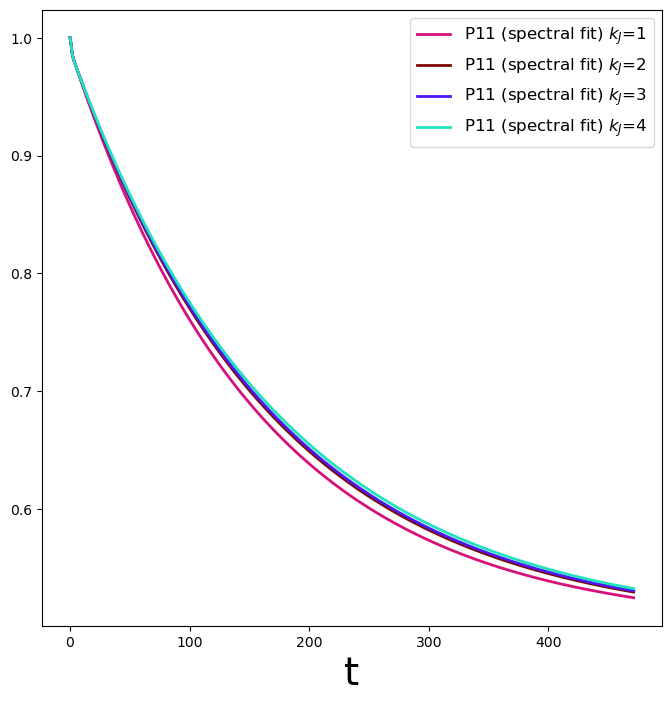

In [23]:
# Generate results for different number of lorentzians in fit:

results_spectral_fit_pk = [
    generate_spectrum_results(obp, params, Nk=1, max_depth=max_depth)
    for params in params_k
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) $k_J$={pk + 1}",
    )
    for pk, result in enumerate(results_spectral_fit_pk)
]);

RHS construction time: 0.7013399600982666


 [          0%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.59s / Remaining 00:00:00:58

 [          1%           ] Elapsed 0.64s / Remaining 00:00:01:03

 [          1%           ] Elapsed 0.68s / Remaining 00:00:01:07

 [          1%           ] Elapsed 0.72s / Remaining 00:00:01:11

 [          1%           ] Elapsed 0.76s / Remaining 00:00:01:15

 [          1%           ] Elapsed 0.80s / Remaining 00:00:01:19

 [          2%           ] Elapsed 0.83s / Remaining 00:00:00:40

 [          2%           ] Elapsed 0.88s / Remaining 00:00:00:42

 [          2%           ] Elapsed 0.91s / Remaining 00:00:00:44

 [          2%           ] Elapsed 0.95s / Remaining 00:00:00:46

 [          2%           ] Elapsed 0.99s / Remaining 00:00:00:48

 [          2%           ] Elapsed 1.03s / Remaining 00:00:00:50

 [*         3%           ] Elapsed 1.07s / Remaining 00:00:00:34

 [*         3%           ] Elapsed 1.11s / Remaining 00:00:00:35

 [*         3%           ] Elapsed 1.15s / Remaining 00:00:00:37

 [*         3%           ] Elapsed 1.19s / Remaining 00:00:00:38

 [*         3%           ] Elapsed 1.23s / Remaining 00:00:00:39

 [*         3%           ] Elapsed 1.26s / Remaining 00:00:00:40

 [*         4%           ] Elapsed 1.30s / Remaining 00:00:00:31

 [*         4%           ] Elapsed 1.34s / Remaining 00:00:00:32

 [*         4%           ] Elapsed 1.38s / Remaining 00:00:00:33

 [*         4%           ] Elapsed 1.42s / Remaining 00:00:00:34

 [*         4%           ] Elapsed 1.46s / Remaining 00:00:00:35

 [*         4%           ] Elapsed 1.50s / Remaining 00:00:00:36

 [*         5%           ] Elapsed 1.54s / Remaining 00:00:00:29

 [*         5%           ] Elapsed 1.58s / Remaining 00:00:00:29

 [*         5%           ] Elapsed 1.61s / Remaining 00:00:00:30

 [*         5%           ] Elapsed 1.66s / Remaining 00:00:00:31

 [*         5%           ] Elapsed 1.70s / Remaining 00:00:00:32

 [*         5%           ] Elapsed 1.73s / Remaining 00:00:00:32

 [*         6%           ] Elapsed 1.77s / Remaining 00:00:00:27

 [*         6%           ] Elapsed 1.81s / Remaining 00:00:00:28

 [*         6%           ] Elapsed 1.85s / Remaining 00:00:00:29

 [*         6%           ] Elapsed 1.89s / Remaining 00:00:00:29

 [*         6%           ] Elapsed 1.93s / Remaining 00:00:00:30

 [*         6%           ] Elapsed 1.97s / Remaining 00:00:00:30

 [**        7%           ] Elapsed 2.01s / Remaining 00:00:00:26

 [**        7%           ] Elapsed 2.05s / Remaining 00:00:00:27

 [**        7%           ] Elapsed 2.09s / Remaining 00:00:00:27

 [**        7%           ] Elapsed 2.13s / Remaining 00:00:00:28

 [**        7%           ] Elapsed 2.16s / Remaining 00:00:00:28

 [**        7%           ] Elapsed 2.21s / Remaining 00:00:00:29

 [**        8%           ] Elapsed 2.25s / Remaining 00:00:00:25

 [**        8%           ] Elapsed 2.28s / Remaining 00:00:00:26

 [**        8%           ] Elapsed 2.32s / Remaining 00:00:00:26

 [**        8%           ] Elapsed 2.36s / Remaining 00:00:00:27

 [**        8%           ] Elapsed 2.40s / Remaining 00:00:00:27

 [**        8%           ] Elapsed 2.44s / Remaining 00:00:00:28

 [**        9%           ] Elapsed 2.48s / Remaining 00:00:00:25

 [**        9%           ] Elapsed 2.52s / Remaining 00:00:00:25

 [**        9%           ] Elapsed 2.56s / Remaining 00:00:00:25

 [**        9%           ] Elapsed 2.60s / Remaining 00:00:00:26

 [**        9%           ] Elapsed 2.64s / Remaining 00:00:00:26

 [**        9%           ] Elapsed 2.68s / Remaining 00:00:00:27

 [**       10%           ] Elapsed 2.72s / Remaining 00:00:00:24

 [**       10%           ] Elapsed 2.76s / Remaining 00:00:00:24

 [**       10%           ] Elapsed 2.80s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.84s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.88s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.92s / Remaining 00:00:00:26

 [***      11%           ] Elapsed 2.96s / Remaining 00:00:00:23

 [***      11%           ] Elapsed 2.99s / Remaining 00:00:00:24

 [***      11%           ] Elapsed 3.04s / Remaining 00:00:00:24

 [***      11%           ] Elapsed 3.07s / Remaining 00:00:00:24

 [***      11%           ] Elapsed 3.12s / Remaining 00:00:00:25

 [***      11%           ] Elapsed 3.16s / Remaining 00:00:00:25

 [***      12%           ] Elapsed 3.19s / Remaining 00:00:00:23

 [***      12%           ] Elapsed 3.24s / Remaining 00:00:00:23

 [***      12%           ] Elapsed 3.27s / Remaining 00:00:00:23

 [***      12%           ] Elapsed 3.32s / Remaining 00:00:00:24

 [***      12%           ] Elapsed 3.36s / Remaining 00:00:00:24

 [***      12%           ] Elapsed 3.40s / Remaining 00:00:00:24

 [***      13%           ] Elapsed 3.44s / Remaining 00:00:00:23

 [***      13%           ] Elapsed 3.48s / Remaining 00:00:00:23

 [***      13%           ] Elapsed 3.52s / Remaining 00:00:00:23

 [***      13%           ] Elapsed 3.56s / Remaining 00:00:00:23

 [***      13%           ] Elapsed 3.60s / Remaining 00:00:00:24

 [***      13%           ] Elapsed 3.63s / Remaining 00:00:00:24

 [***      14%           ] Elapsed 3.68s / Remaining 00:00:00:22

 [***      14%           ] Elapsed 3.71s / Remaining 00:00:00:22

 [***      14%           ] Elapsed 3.75s / Remaining 00:00:00:23

 [***      14%           ] Elapsed 3.80s / Remaining 00:00:00:23

 [***      14%           ] Elapsed 3.83s / Remaining 00:00:00:23

 [***      14%           ] Elapsed 3.87s / Remaining 00:00:00:23

 [***      15%           ] Elapsed 3.91s / Remaining 00:00:00:22

 [***      15%           ] Elapsed 3.95s / Remaining 00:00:00:22

 [***      15%           ] Elapsed 3.99s / Remaining 00:00:00:22

 [***      15%           ] Elapsed 4.03s / Remaining 00:00:00:22

 [***      15%           ] Elapsed 4.07s / Remaining 00:00:00:23

 [***      15%           ] Elapsed 4.10s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.15s / Remaining 00:00:00:21

 [****     16%           ] Elapsed 4.18s / Remaining 00:00:00:21

 [****     16%           ] Elapsed 4.22s / Remaining 00:00:00:22

 [****     16%           ] Elapsed 4.26s / Remaining 00:00:00:22

 [****     16%           ] Elapsed 4.30s / Remaining 00:00:00:22

 [****     16%           ] Elapsed 4.34s / Remaining 00:00:00:22

 [****     17%           ] Elapsed 4.38s / Remaining 00:00:00:21

 [****     17%           ] Elapsed 4.42s / Remaining 00:00:00:21

 [****     17%           ] Elapsed 4.46s / Remaining 00:00:00:21

 [****     17%           ] Elapsed 4.50s / Remaining 00:00:00:21

 [****     17%           ] Elapsed 4.53s / Remaining 00:00:00:22

 [****     17%           ] Elapsed 4.58s / Remaining 00:00:00:22

 [****     18%           ] Elapsed 4.62s / Remaining 00:00:00:21

 [****     18%           ] Elapsed 4.65s / Remaining 00:00:00:21

 [****     18%           ] Elapsed 4.70s / Remaining 00:00:00:21

 [****     18%           ] Elapsed 4.73s / Remaining 00:00:00:21

 [****     18%           ] Elapsed 4.77s / Remaining 00:00:00:21

 [****     18%           ] Elapsed 4.81s / Remaining 00:00:00:21

 [****     19%           ] Elapsed 4.85s / Remaining 00:00:00:20

 [****     19%           ] Elapsed 4.89s / Remaining 00:00:00:20

 [****     19%           ] Elapsed 4.93s / Remaining 00:00:00:21

 [****     19%           ] Elapsed 4.97s / Remaining 00:00:00:21

 [****     19%           ] Elapsed 5.01s / Remaining 00:00:00:21

 [****     19%           ] Elapsed 5.05s / Remaining 00:00:00:21

 [*****    20%           ] Elapsed 5.09s / Remaining 00:00:00:20

 [*****    20%           ] Elapsed 5.13s / Remaining 00:00:00:20

 [*****    20%           ] Elapsed 5.17s / Remaining 00:00:00:20

 [*****    20%           ] Elapsed 5.20s / Remaining 00:00:00:20

 [*****    20%           ] Elapsed 5.25s / Remaining 00:00:00:20

 [*****    20%           ] Elapsed 5.28s / Remaining 00:00:00:21

 [*****    21%           ] Elapsed 5.32s / Remaining 00:00:00:20

 [*****    21%           ] Elapsed 5.36s / Remaining 00:00:00:20

 [*****    21%           ] Elapsed 5.40s / Remaining 00:00:00:20

 [*****    21%           ] Elapsed 5.44s / Remaining 00:00:00:20

 [*****    21%           ] Elapsed 5.48s / Remaining 00:00:00:20

 [*****    21%           ] Elapsed 5.52s / Remaining 00:00:00:20

 [*****    22%           ] Elapsed 5.56s / Remaining 00:00:00:19

 [*****    22%           ] Elapsed 5.60s / Remaining 00:00:00:19

 [*****    22%           ] Elapsed 5.64s / Remaining 00:00:00:19

 [*****    22%           ] Elapsed 5.68s / Remaining 00:00:00:20

 [*****    22%           ] Elapsed 5.72s / Remaining 00:00:00:20

 [*****    22%           ] Elapsed 5.76s / Remaining 00:00:00:20

 [*****    23%           ] Elapsed 5.80s / Remaining 00:00:00:19

 [*****    23%           ] Elapsed 5.84s / Remaining 00:00:00:19

 [*****    23%           ] Elapsed 5.88s / Remaining 00:00:00:19

 [*****    23%           ] Elapsed 5.91s / Remaining 00:00:00:19

 [*****    23%           ] Elapsed 5.96s / Remaining 00:00:00:19

 [*****    23%           ] Elapsed 5.99s / Remaining 00:00:00:20

 [******   24%           ] Elapsed 6.03s / Remaining 00:00:00:19

 [******   24%           ] Elapsed 6.08s / Remaining 00:00:00:19

 [******   24%           ] Elapsed 6.11s / Remaining 00:00:00:19

 [******   24%           ] Elapsed 6.16s / Remaining 00:00:00:19

 [******   24%           ] Elapsed 6.20s / Remaining 00:00:00:19

 [******   24%           ] Elapsed 6.24s / Remaining 00:00:00:19

 [******   25%           ] Elapsed 6.28s / Remaining 00:00:00:18

 [******   25%           ] Elapsed 6.32s / Remaining 00:00:00:18

 [******   25%           ] Elapsed 6.36s / Remaining 00:00:00:19

 [******   25%           ] Elapsed 6.40s / Remaining 00:00:00:19

 [******   25%           ] Elapsed 6.44s / Remaining 00:00:00:19

 [******   25%           ] Elapsed 6.48s / Remaining 00:00:00:19

 [******   26%           ] Elapsed 6.52s / Remaining 00:00:00:18

 [******   26%           ] Elapsed 6.56s / Remaining 00:00:00:18

 [******   26%           ] Elapsed 6.60s / Remaining 00:00:00:18

 [******   26%           ] Elapsed 6.65s / Remaining 00:00:00:18

 [******   26%           ] Elapsed 6.68s / Remaining 00:00:00:19

 [******   26%           ] Elapsed 6.73s / Remaining 00:00:00:19

 [******   27%           ] Elapsed 6.77s / Remaining 00:00:00:18

 [******   27%           ] Elapsed 6.81s / Remaining 00:00:00:18

 [******   27%           ] Elapsed 6.85s / Remaining 00:00:00:18

 [******   27%           ] Elapsed 6.89s / Remaining 00:00:00:18

 [******   27%           ] Elapsed 6.93s / Remaining 00:00:00:18

 [******   27%           ] Elapsed 6.97s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.01s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.05s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.09s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.13s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.18s / Remaining 00:00:00:18

 [******   28%           ] Elapsed 7.22s / Remaining 00:00:00:18

 [*******  29%           ] Elapsed 7.26s / Remaining 00:00:00:17

 [*******  29%           ] Elapsed 7.30s / Remaining 00:00:00:17

 [*******  29%           ] Elapsed 7.34s / Remaining 00:00:00:17

 [*******  29%           ] Elapsed 7.38s / Remaining 00:00:00:18

 [*******  29%           ] Elapsed 7.42s / Remaining 00:00:00:18

 [*******  29%           ] Elapsed 7.46s / Remaining 00:00:00:18

 [*******  30%           ] Elapsed 7.50s / Remaining 00:00:00:17

 [*******  30%           ] Elapsed 7.54s / Remaining 00:00:00:17

 [*******  30%           ] Elapsed 7.58s / Remaining 00:00:00:17

 [*******  30%           ] Elapsed 7.62s / Remaining 00:00:00:17

 [*******  30%           ] Elapsed 7.66s / Remaining 00:00:00:17

 [*******  30%           ] Elapsed 7.70s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.74s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.79s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.84s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.88s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.92s / Remaining 00:00:00:17

 [*******  31%           ] Elapsed 7.96s / Remaining 00:00:00:17

 [*******  32%           ] Elapsed 8.00s / Remaining 00:00:00:16

 [*******  32%           ] Elapsed 8.04s / Remaining 00:00:00:17

 [*******  32%           ] Elapsed 8.08s / Remaining 00:00:00:17

 [*******  32%           ] Elapsed 8.12s / Remaining 00:00:00:17

 [*******  32%           ] Elapsed 8.17s / Remaining 00:00:00:17

 [*******  32%           ] Elapsed 8.20s / Remaining 00:00:00:17

 [******** 33%           ] Elapsed 8.25s / Remaining 00:00:00:16

 [******** 33%           ] Elapsed 8.28s / Remaining 00:00:00:16

 [******** 33%           ] Elapsed 8.33s / Remaining 00:00:00:16

 [******** 33%           ] Elapsed 8.36s / Remaining 00:00:00:16

 [******** 33%           ] Elapsed 8.41s / Remaining 00:00:00:17

 [******** 33%           ] Elapsed 8.45s / Remaining 00:00:00:17

 [******** 34%           ] Elapsed 8.49s / Remaining 00:00:00:16

 [******** 34%           ] Elapsed 8.53s / Remaining 00:00:00:16

 [******** 34%           ] Elapsed 8.57s / Remaining 00:00:00:16

 [******** 34%           ] Elapsed 8.61s / Remaining 00:00:00:16

 [******** 34%           ] Elapsed 8.65s / Remaining 00:00:00:16

 [******** 34%           ] Elapsed 8.69s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.74s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.77s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.82s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.85s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.90s / Remaining 00:00:00:16

 [******** 35%           ] Elapsed 8.94s / Remaining 00:00:00:16

 [******** 36%           ] Elapsed 8.98s / Remaining 00:00:00:15

 [******** 36%           ] Elapsed 9.02s / Remaining 00:00:00:16

 [******** 36%           ] Elapsed 9.06s / Remaining 00:00:00:16

 [******** 36%           ] Elapsed 9.10s / Remaining 00:00:00:16

 [******** 36%           ] Elapsed 9.14s / Remaining 00:00:00:16

 [******** 36%           ] Elapsed 9.18s / Remaining 00:00:00:16

 [*********37%           ] Elapsed 9.22s / Remaining 00:00:00:15

 [*********37%           ] Elapsed 9.27s / Remaining 00:00:00:15

 [*********37%           ] Elapsed 9.31s / Remaining 00:00:00:15

 [*********37%           ] Elapsed 9.35s / Remaining 00:00:00:15

 [*********37%           ] Elapsed 9.39s / Remaining 00:00:00:15

 [*********37%           ] Elapsed 9.43s / Remaining 00:00:00:16

 [*********38%           ] Elapsed 9.47s / Remaining 00:00:00:15

 [*********38%           ] Elapsed 9.51s / Remaining 00:00:00:15

 [*********38%           ] Elapsed 9.55s / Remaining 00:00:00:15

 [*********38%           ] Elapsed 9.59s / Remaining 00:00:00:15

 [*********38%           ] Elapsed 9.63s / Remaining 00:00:00:15

 [*********38%           ] Elapsed 9.68s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.71s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.76s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.79s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.84s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.88s / Remaining 00:00:00:15

 [*********39%           ] Elapsed 9.92s / Remaining 00:00:00:15

 [*********40%           ] Elapsed 9.96s / Remaining 00:00:00:14

 [*********40%           ] Elapsed 10.00s / Remaining 00:00:00:14

 [*********40%           ] Elapsed 10.04s / Remaining 00:00:00:15

 [*********40%           ] Elapsed 10.08s / Remaining 00:00:00:15

 [*********40%           ] Elapsed 10.12s / Remaining 00:00:00:15

 [*********40%           ] Elapsed 10.16s / Remaining 00:00:00:15

 [*********41%           ] Elapsed 10.20s / Remaining 00:00:00:14

 [*********41%           ] Elapsed 10.24s / Remaining 00:00:00:14

 [*********41%           ] Elapsed 10.28s / Remaining 00:00:00:14

 [*********41%           ] Elapsed 10.32s / Remaining 00:00:00:14

 [*********41%           ] Elapsed 10.36s / Remaining 00:00:00:14

 [*********41%           ] Elapsed 10.41s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.44s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.49s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.53s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.57s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.61s / Remaining 00:00:00:14

 [*********42%           ] Elapsed 10.65s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.69s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.73s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.77s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.81s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.85s / Remaining 00:00:00:14

 [*********43%           ] Elapsed 10.89s / Remaining 00:00:00:14

 [*********44%           ] Elapsed 10.93s / Remaining 00:00:00:13

 [*********44%           ] Elapsed 10.97s / Remaining 00:00:00:13

 [*********44%           ] Elapsed 11.01s / Remaining 00:00:00:14

 [*********44%           ] Elapsed 11.05s / Remaining 00:00:00:14

 [*********44%           ] Elapsed 11.10s / Remaining 00:00:00:14

 [*********44%           ] Elapsed 11.13s / Remaining 00:00:00:14

 [*********45%           ] Elapsed 11.18s / Remaining 00:00:00:13

 [*********45%           ] Elapsed 11.21s / Remaining 00:00:00:13

 [*********45%           ] Elapsed 11.26s / Remaining 00:00:00:13

 [*********45%           ] Elapsed 11.29s / Remaining 00:00:00:13

 [*********45%           ] Elapsed 11.34s / Remaining 00:00:00:13

 [*********45%           ] Elapsed 11.38s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.42s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.46s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.50s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.54s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.58s / Remaining 00:00:00:13

 [*********46%           ] Elapsed 11.62s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.66s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.70s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.75s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.78s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.83s / Remaining 00:00:00:13

 [*********47%           ] Elapsed 11.86s / Remaining 00:00:00:13

 [*********48%           ] Elapsed 11.91s / Remaining 00:00:00:12

 [*********48%           ] Elapsed 11.94s / Remaining 00:00:00:12

 [*********48%           ] Elapsed 11.99s / Remaining 00:00:00:12

 [*********48%           ] Elapsed 12.03s / Remaining 00:00:00:13

 [*********48%           ] Elapsed 12.07s / Remaining 00:00:00:13

 [*********48%           ] Elapsed 12.11s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 12.15s / Remaining 00:00:00:12

 [*********49%           ] Elapsed 12.19s / Remaining 00:00:00:12

 [*********49%           ] Elapsed 12.23s / Remaining 00:00:00:12

 [*********49%           ] Elapsed 12.27s / Remaining 00:00:00:12

 [*********49%           ] Elapsed 12.31s / Remaining 00:00:00:12

 [*********49%           ] Elapsed 12.35s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.39s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.43s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.47s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.51s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.55s / Remaining 00:00:00:12

 [*********50%           ] Elapsed 12.59s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.63s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.67s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.71s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.75s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.79s / Remaining 00:00:00:12

 [*********51%           ] Elapsed 12.84s / Remaining 00:00:00:12

 [*********52%           ] Elapsed 12.88s / Remaining 00:00:00:11

 [*********52%           ] Elapsed 12.92s / Remaining 00:00:00:11

 [*********52%           ] Elapsed 12.96s / Remaining 00:00:00:11

 [*********52%           ] Elapsed 13.00s / Remaining 00:00:00:11

 [*********52%           ] Elapsed 13.04s / Remaining 00:00:00:12

 [*********52%           ] Elapsed 13.08s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 13.12s / Remaining 00:00:00:11

 [*********53%           ] Elapsed 13.16s / Remaining 00:00:00:11

 [*********53%           ] Elapsed 13.20s / Remaining 00:00:00:11

 [*********53%           ] Elapsed 13.24s / Remaining 00:00:00:11

 [*********53%           ] Elapsed 13.28s / Remaining 00:00:00:11

 [*********53%           ] Elapsed 13.32s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.36s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.40s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.44s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.48s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.52s / Remaining 00:00:00:11

 [*********54%           ] Elapsed 13.56s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.60s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.64s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.68s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.72s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.76s / Remaining 00:00:00:11

 [*********55%*          ] Elapsed 13.80s / Remaining 00:00:00:11

 [*********56%*          ] Elapsed 13.84s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 13.88s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 13.92s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 13.96s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 14.00s / Remaining 00:00:00:10

 [*********56%*          ] Elapsed 14.04s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 14.09s / Remaining 00:00:00:10

 [*********57%*          ] Elapsed 14.12s / Remaining 00:00:00:10

 [*********57%*          ] Elapsed 14.17s / Remaining 00:00:00:10

 [*********57%*          ] Elapsed 14.20s / Remaining 00:00:00:10

 [*********57%*          ] Elapsed 14.25s / Remaining 00:00:00:10

 [*********57%*          ] Elapsed 14.28s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.33s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.37s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.41s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.45s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.49s / Remaining 00:00:00:10

 [*********58%*          ] Elapsed 14.53s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.57s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.61s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.65s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.69s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.73s / Remaining 00:00:00:10

 [*********59%**         ] Elapsed 14.77s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 14.81s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 14.85s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 14.90s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 14.94s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 14.98s / Remaining 00:00:00:09

 [*********60%**         ] Elapsed 15.02s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 15.06s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 15.10s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 15.14s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 15.18s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 15.22s / Remaining 00:00:00:09

 [*********61%**         ] Elapsed 15.26s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.30s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.34s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.38s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.42s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.47s / Remaining 00:00:00:09

 [*********62%**         ] Elapsed 15.51s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.55s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.59s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.63s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.68s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.72s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 15.76s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 15.80s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 15.84s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 15.88s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 15.92s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 15.96s / Remaining 00:00:00:08

 [*********64%***        ] Elapsed 16.00s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.04s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.08s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.12s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.16s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.20s / Remaining 00:00:00:08

 [*********65%***        ] Elapsed 16.24s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.28s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.32s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.36s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.40s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.45s / Remaining 00:00:00:08

 [*********66%***        ] Elapsed 16.48s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.53s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.56s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.61s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.64s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.69s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 16.73s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 16.77s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 16.81s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 16.85s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 16.89s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 16.93s / Remaining 00:00:00:07

 [*********68%****       ] Elapsed 16.97s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.01s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.05s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.10s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.14s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.18s / Remaining 00:00:00:07

 [*********69%****       ] Elapsed 17.22s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.26s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.30s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.34s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.39s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.42s / Remaining 00:00:00:07

 [*********70%****       ] Elapsed 17.47s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.50s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.55s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.59s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.63s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.67s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 17.71s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 17.75s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 17.79s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 17.83s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 17.87s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 17.91s / Remaining 00:00:00:06

 [*********72%*****      ] Elapsed 17.96s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 17.99s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 18.04s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 18.07s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 18.12s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 18.15s / Remaining 00:00:00:06

 [*********73%*****      ] Elapsed 18.20s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.24s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.28s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.32s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.36s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.40s / Remaining 00:00:00:06

 [*********74%*****      ] Elapsed 18.44s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.48s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.52s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.56s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.61s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.64s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 18.69s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 18.72s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 18.77s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 18.81s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 18.85s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 18.89s / Remaining 00:00:00:05

 [*********76%*****      ] Elapsed 18.93s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 18.98s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 19.01s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 19.06s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 19.10s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 19.14s / Remaining 00:00:00:05

 [*********77%******     ] Elapsed 19.18s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.22s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.26s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.30s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.34s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.38s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 19.42s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.46s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.50s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.55s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.58s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.63s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 19.67s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 19.71s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 19.75s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 19.79s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 19.83s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 19.87s / Remaining 00:00:00:04

 [*********80%******     ] Elapsed 19.91s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 19.95s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 19.99s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 20.03s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 20.07s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 20.11s / Remaining 00:00:00:04

 [*********81%*******    ] Elapsed 20.15s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.19s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.23s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.27s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.31s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.35s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 20.39s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.43s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.47s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.51s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.55s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.60s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 20.63s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 20.68s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 20.71s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 20.75s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 20.79s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 20.83s / Remaining 00:00:00:03

 [*********84%*******    ] Elapsed 20.88s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 20.91s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 20.96s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 20.99s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 21.04s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 21.07s / Remaining 00:00:00:03

 [*********85%********   ] Elapsed 21.12s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.16s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.20s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.24s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.27s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.32s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 21.35s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.40s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.44s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.48s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.52s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.56s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 21.60s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 21.64s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 21.68s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 21.72s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 21.76s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 21.80s / Remaining 00:00:00:02

 [*********88%********   ] Elapsed 21.84s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 21.88s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 21.92s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 21.96s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 22.00s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 22.04s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 22.08s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.12s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.16s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.20s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.24s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.28s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 22.32s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.37s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.40s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.45s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.48s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.52s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 22.56s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 22.60s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 22.65s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 22.69s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 22.73s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 22.77s / Remaining 00:00:00:01

 [*********92%*********  ] Elapsed 22.81s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 22.85s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 22.89s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 22.93s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 22.97s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 23.01s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 23.05s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.09s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.13s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.17s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.22s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.25s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 23.30s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.33s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.38s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.41s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.46s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.49s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 23.53s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 23.58s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 23.61s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 23.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 23.69s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 23.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 23.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 23.82s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 23.86s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 23.90s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 23.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 23.98s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 24.02s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.06s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.10s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.14s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.18s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.22s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 24.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.34s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.43s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.46s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 24.51s / Remaining 00:00:00:00

 [********100%***********] Elapsed 24.54s / Remaining 00:00:00:00

 [********100%***********] Elapsed 24.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 24.62s / Remaining 00:00:00:00

 Total run time:  24.63s
ODE solver time: 24.627005577087402


RHS construction time: 1.0659370422363281


 [          0%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.86s / Remaining 00:00:01:25

 [          1%           ] Elapsed 0.94s / Remaining 00:00:01:32

 [          1%           ] Elapsed 1.00s / Remaining 00:00:01:38

 [          1%           ] Elapsed 1.09s / Remaining 00:00:01:48

 [          1%           ] Elapsed 1.17s / Remaining 00:00:01:56

 [          1%           ] Elapsed 1.26s / Remaining 00:00:02:04

 [          2%           ] Elapsed 1.37s / Remaining 00:00:01:07

 [          2%           ] Elapsed 1.47s / Remaining 00:00:01:12

 [          2%           ] Elapsed 1.57s / Remaining 00:00:01:16

 [          2%           ] Elapsed 1.67s / Remaining 00:00:01:21

 [          2%           ] Elapsed 1.76s / Remaining 00:00:01:26

 [          2%           ] Elapsed 1.86s / Remaining 00:00:01:31

 [*         3%           ] Elapsed 1.96s / Remaining 00:00:01:03

 [*         3%           ] Elapsed 2.06s / Remaining 00:00:01:06

 [*         3%           ] Elapsed 2.16s / Remaining 00:00:01:09

 [*         3%           ] Elapsed 2.26s / Remaining 00:00:01:12

 [*         3%           ] Elapsed 2.35s / Remaining 00:00:01:16

 [*         3%           ] Elapsed 2.46s / Remaining 00:00:01:19

 [*         4%           ] Elapsed 2.56s / Remaining 00:00:01:01

 [*         4%           ] Elapsed 2.65s / Remaining 00:00:01:03

 [*         4%           ] Elapsed 2.75s / Remaining 00:00:01:06

 [*         4%           ] Elapsed 2.87s / Remaining 00:00:01:08

 [*         4%           ] Elapsed 2.96s / Remaining 00:00:01:11

 [*         4%           ] Elapsed 3.06s / Remaining 00:00:01:13

 [*         5%           ] Elapsed 3.16s / Remaining 00:00:01:00

 [*         5%           ] Elapsed 3.26s / Remaining 00:00:01:02

 [*         5%           ] Elapsed 3.36s / Remaining 00:00:01:03

 [*         5%           ] Elapsed 3.46s / Remaining 00:00:01:05

 [*         5%           ] Elapsed 3.56s / Remaining 00:00:01:07

 [*         5%           ] Elapsed 3.66s / Remaining 00:00:01:09

 [*         6%           ] Elapsed 3.76s / Remaining 00:00:00:58

 [*         6%           ] Elapsed 3.85s / Remaining 00:00:01:00

 [*         6%           ] Elapsed 3.96s / Remaining 00:00:01:01

 [*         6%           ] Elapsed 4.05s / Remaining 00:00:01:03

 [*         6%           ] Elapsed 4.15s / Remaining 00:00:01:05

 [*         6%           ] Elapsed 4.25s / Remaining 00:00:01:06

 [**        7%           ] Elapsed 4.34s / Remaining 00:00:00:57

 [**        7%           ] Elapsed 4.46s / Remaining 00:00:00:59

 [**        7%           ] Elapsed 4.55s / Remaining 00:00:01:00

 [**        7%           ] Elapsed 4.65s / Remaining 00:00:01:01

 [**        7%           ] Elapsed 4.76s / Remaining 00:00:01:03

 [**        7%           ] Elapsed 4.85s / Remaining 00:00:01:04

 [**        8%           ] Elapsed 4.95s / Remaining 00:00:00:56

 [**        8%           ] Elapsed 5.05s / Remaining 00:00:00:58

 [**        8%           ] Elapsed 5.15s / Remaining 00:00:00:59

 [**        8%           ] Elapsed 5.25s / Remaining 00:00:01:00

 [**        8%           ] Elapsed 5.35s / Remaining 00:00:01:01

 [**        8%           ] Elapsed 5.45s / Remaining 00:00:01:02

 [**        9%           ] Elapsed 5.56s / Remaining 00:00:00:56

 [**        9%           ] Elapsed 5.66s / Remaining 00:00:00:57

 [**        9%           ] Elapsed 5.75s / Remaining 00:00:00:58

 [**        9%           ] Elapsed 5.85s / Remaining 00:00:00:59

 [**        9%           ] Elapsed 5.97s / Remaining 00:00:01:00

 [**        9%           ] Elapsed 6.06s / Remaining 00:00:01:01

 [**       10%           ] Elapsed 6.16s / Remaining 00:00:00:55

 [**       10%           ] Elapsed 6.27s / Remaining 00:00:00:56

 [**       10%           ] Elapsed 6.36s / Remaining 00:00:00:57

 [**       10%           ] Elapsed 6.46s / Remaining 00:00:00:58

 [**       10%           ] Elapsed 6.56s / Remaining 00:00:00:59

 [**       10%           ] Elapsed 6.67s / Remaining 00:00:01:00

 [***      11%           ] Elapsed 6.77s / Remaining 00:00:00:54

 [***      11%           ] Elapsed 6.86s / Remaining 00:00:00:55

 [***      11%           ] Elapsed 6.96s / Remaining 00:00:00:56

 [***      11%           ] Elapsed 7.07s / Remaining 00:00:00:57

 [***      11%           ] Elapsed 7.17s / Remaining 00:00:00:57

 [***      11%           ] Elapsed 7.26s / Remaining 00:00:00:58

 [***      12%           ] Elapsed 7.36s / Remaining 00:00:00:53

 [***      12%           ] Elapsed 7.48s / Remaining 00:00:00:54

 [***      12%           ] Elapsed 7.58s / Remaining 00:00:00:55

 [***      12%           ] Elapsed 7.68s / Remaining 00:00:00:56

 [***      12%           ] Elapsed 7.78s / Remaining 00:00:00:57

 [***      12%           ] Elapsed 7.89s / Remaining 00:00:00:57

 [***      13%           ] Elapsed 7.98s / Remaining 00:00:00:53

 [***      13%           ] Elapsed 8.08s / Remaining 00:00:00:54

 [***      13%           ] Elapsed 8.19s / Remaining 00:00:00:54

 [***      13%           ] Elapsed 8.29s / Remaining 00:00:00:55

 [***      13%           ] Elapsed 8.38s / Remaining 00:00:00:56

 [***      13%           ] Elapsed 8.48s / Remaining 00:00:00:56

 [***      14%           ] Elapsed 8.58s / Remaining 00:00:00:52

 [***      14%           ] Elapsed 8.68s / Remaining 00:00:00:53

 [***      14%           ] Elapsed 8.77s / Remaining 00:00:00:53

 [***      14%           ] Elapsed 8.87s / Remaining 00:00:00:54

 [***      14%           ] Elapsed 8.99s / Remaining 00:00:00:55

 [***      14%           ] Elapsed 9.08s / Remaining 00:00:00:55

 [***      15%           ] Elapsed 9.18s / Remaining 00:00:00:52

 [***      15%           ] Elapsed 9.28s / Remaining 00:00:00:52

 [***      15%           ] Elapsed 9.38s / Remaining 00:00:00:53

 [***      15%           ] Elapsed 9.48s / Remaining 00:00:00:53

 [***      15%           ] Elapsed 9.58s / Remaining 00:00:00:54

 [***      15%           ] Elapsed 9.69s / Remaining 00:00:00:54

 [****     16%           ] Elapsed 9.78s / Remaining 00:00:00:51

 [****     16%           ] Elapsed 9.88s / Remaining 00:00:00:51

 [****     16%           ] Elapsed 9.98s / Remaining 00:00:00:52

 [****     16%           ] Elapsed 10.09s / Remaining 00:00:00:52

 [****     16%           ] Elapsed 10.19s / Remaining 00:00:00:53

 [****     16%           ] Elapsed 10.28s / Remaining 00:00:00:53

 [****     17%           ] Elapsed 10.38s / Remaining 00:00:00:50

 [****     17%           ] Elapsed 10.50s / Remaining 00:00:00:51

 [****     17%           ] Elapsed 10.60s / Remaining 00:00:00:51

 [****     17%           ] Elapsed 10.70s / Remaining 00:00:00:52

 [****     17%           ] Elapsed 10.79s / Remaining 00:00:00:52

 [****     17%           ] Elapsed 10.90s / Remaining 00:00:00:53

 [****     18%           ] Elapsed 11.00s / Remaining 00:00:00:50

 [****     18%           ] Elapsed 11.10s / Remaining 00:00:00:50

 [****     18%           ] Elapsed 11.21s / Remaining 00:00:00:51

 [****     18%           ] Elapsed 11.31s / Remaining 00:00:00:51

 [****     18%           ] Elapsed 11.41s / Remaining 00:00:00:51

 [****     18%           ] Elapsed 11.51s / Remaining 00:00:00:52

 [****     19%           ] Elapsed 11.61s / Remaining 00:00:00:49

 [****     19%           ] Elapsed 11.71s / Remaining 00:00:00:49

 [****     19%           ] Elapsed 11.81s / Remaining 00:00:00:50

 [****     19%           ] Elapsed 11.91s / Remaining 00:00:00:50

 [****     19%           ] Elapsed 12.01s / Remaining 00:00:00:51

 [****     19%           ] Elapsed 12.12s / Remaining 00:00:00:51

 [*****    20%           ] Elapsed 12.22s / Remaining 00:00:00:48

 [*****    20%           ] Elapsed 12.32s / Remaining 00:00:00:49

 [*****    20%           ] Elapsed 12.43s / Remaining 00:00:00:49

 [*****    20%           ] Elapsed 12.53s / Remaining 00:00:00:50

 [*****    20%           ] Elapsed 12.63s / Remaining 00:00:00:50

 [*****    20%           ] Elapsed 12.72s / Remaining 00:00:00:50

 [*****    21%           ] Elapsed 12.83s / Remaining 00:00:00:48

 [*****    21%           ] Elapsed 12.93s / Remaining 00:00:00:48

 [*****    21%           ] Elapsed 13.04s / Remaining 00:00:00:49

 [*****    21%           ] Elapsed 13.14s / Remaining 00:00:00:49

 [*****    21%           ] Elapsed 13.26s / Remaining 00:00:00:49

 [*****    21%           ] Elapsed 13.37s / Remaining 00:00:00:50

 [*****    22%           ] Elapsed 13.49s / Remaining 00:00:00:47

 [*****    22%           ] Elapsed 13.59s / Remaining 00:00:00:48

 [*****    22%           ] Elapsed 13.71s / Remaining 00:00:00:48

 [*****    22%           ] Elapsed 13.80s / Remaining 00:00:00:48

 [*****    22%           ] Elapsed 13.90s / Remaining 00:00:00:49

 [*****    22%           ] Elapsed 14.01s / Remaining 00:00:00:49

 [*****    23%           ] Elapsed 14.11s / Remaining 00:00:00:47

 [*****    23%           ] Elapsed 14.21s / Remaining 00:00:00:47

 [*****    23%           ] Elapsed 14.30s / Remaining 00:00:00:47

 [*****    23%           ] Elapsed 14.41s / Remaining 00:00:00:48

 [*****    23%           ] Elapsed 14.51s / Remaining 00:00:00:48

 [*****    23%           ] Elapsed 14.61s / Remaining 00:00:00:48

 [******   24%           ] Elapsed 14.70s / Remaining 00:00:00:46

 [******   24%           ] Elapsed 14.81s / Remaining 00:00:00:46

 [******   24%           ] Elapsed 14.91s / Remaining 00:00:00:47

 [******   24%           ] Elapsed 15.01s / Remaining 00:00:00:47

 [******   24%           ] Elapsed 15.10s / Remaining 00:00:00:47

 [******   24%           ] Elapsed 15.22s / Remaining 00:00:00:48

 [******   25%           ] Elapsed 15.32s / Remaining 00:00:00:45

 [******   25%           ] Elapsed 15.42s / Remaining 00:00:00:46

 [******   25%           ] Elapsed 15.52s / Remaining 00:00:00:46

 [******   25%           ] Elapsed 15.62s / Remaining 00:00:00:46

 [******   25%           ] Elapsed 15.72s / Remaining 00:00:00:47

 [******   25%           ] Elapsed 15.82s / Remaining 00:00:00:47

 [******   26%           ] Elapsed 15.93s / Remaining 00:00:00:45

 [******   26%           ] Elapsed 16.02s / Remaining 00:00:00:45

 [******   26%           ] Elapsed 16.12s / Remaining 00:00:00:45

 [******   26%           ] Elapsed 16.22s / Remaining 00:00:00:46

 [******   26%           ] Elapsed 16.33s / Remaining 00:00:00:46

 [******   26%           ] Elapsed 16.43s / Remaining 00:00:00:46

 [******   27%           ] Elapsed 16.53s / Remaining 00:00:00:44

 [******   27%           ] Elapsed 16.62s / Remaining 00:00:00:44

 [******   27%           ] Elapsed 16.74s / Remaining 00:00:00:45

 [******   27%           ] Elapsed 16.84s / Remaining 00:00:00:45

 [******   27%           ] Elapsed 16.93s / Remaining 00:00:00:45

 [******   27%           ] Elapsed 17.03s / Remaining 00:00:00:46

 [******   28%           ] Elapsed 17.14s / Remaining 00:00:00:44

 [******   28%           ] Elapsed 17.24s / Remaining 00:00:00:44

 [******   28%           ] Elapsed 17.34s / Remaining 00:00:00:44

 [******   28%           ] Elapsed 17.45s / Remaining 00:00:00:44

 [******   28%           ] Elapsed 17.54s / Remaining 00:00:00:45

 [******   28%           ] Elapsed 17.64s / Remaining 00:00:00:45

 [*******  29%           ] Elapsed 17.74s / Remaining 00:00:00:43

 [*******  29%           ] Elapsed 17.85s / Remaining 00:00:00:43

 [*******  29%           ] Elapsed 17.95s / Remaining 00:00:00:43

 [*******  29%           ] Elapsed 18.05s / Remaining 00:00:00:44

 [*******  29%           ] Elapsed 18.14s / Remaining 00:00:00:44

 [*******  29%           ] Elapsed 18.24s / Remaining 00:00:00:44

 [*******  30%           ] Elapsed 18.35s / Remaining 00:00:00:42

 [*******  30%           ] Elapsed 18.45s / Remaining 00:00:00:43

 [*******  30%           ] Elapsed 18.55s / Remaining 00:00:00:43

 [*******  30%           ] Elapsed 18.66s / Remaining 00:00:00:43

 [*******  30%           ] Elapsed 18.75s / Remaining 00:00:00:43

 [*******  30%           ] Elapsed 18.85s / Remaining 00:00:00:43

 [*******  31%           ] Elapsed 18.94s / Remaining 00:00:00:42

 [*******  31%           ] Elapsed 19.05s / Remaining 00:00:00:42

 [*******  31%           ] Elapsed 19.15s / Remaining 00:00:00:42

 [*******  31%           ] Elapsed 19.24s / Remaining 00:00:00:42

 [*******  31%           ] Elapsed 19.34s / Remaining 00:00:00:43

 [*******  31%           ] Elapsed 19.45s / Remaining 00:00:00:43

 [*******  32%           ] Elapsed 19.54s / Remaining 00:00:00:41

 [*******  32%           ] Elapsed 19.64s / Remaining 00:00:00:41

 [*******  32%           ] Elapsed 19.74s / Remaining 00:00:00:41

 [*******  32%           ] Elapsed 19.85s / Remaining 00:00:00:42

 [*******  32%           ] Elapsed 19.95s / Remaining 00:00:00:42

 [*******  32%           ] Elapsed 20.05s / Remaining 00:00:00:42

 [******** 33%           ] Elapsed 20.15s / Remaining 00:00:00:40

 [******** 33%           ] Elapsed 20.25s / Remaining 00:00:00:41

 [******** 33%           ] Elapsed 20.35s / Remaining 00:00:00:41

 [******** 33%           ] Elapsed 20.45s / Remaining 00:00:00:41

 [******** 33%           ] Elapsed 20.56s / Remaining 00:00:00:41

 [******** 33%           ] Elapsed 20.65s / Remaining 00:00:00:41

 [******** 34%           ] Elapsed 20.75s / Remaining 00:00:00:40

 [******** 34%           ] Elapsed 20.85s / Remaining 00:00:00:40

 [******** 34%           ] Elapsed 20.96s / Remaining 00:00:00:40

 [******** 34%           ] Elapsed 21.06s / Remaining 00:00:00:40

 [******** 34%           ] Elapsed 21.15s / Remaining 00:00:00:41

 [******** 34%           ] Elapsed 21.25s / Remaining 00:00:00:41

 [******** 35%           ] Elapsed 21.37s / Remaining 00:00:00:39

 [******** 35%           ] Elapsed 21.47s / Remaining 00:00:00:39

 [******** 35%           ] Elapsed 21.57s / Remaining 00:00:00:40

 [******** 35%           ] Elapsed 21.66s / Remaining 00:00:00:40

 [******** 35%           ] Elapsed 21.77s / Remaining 00:00:00:40

 [******** 35%           ] Elapsed 21.87s / Remaining 00:00:00:40

 [******** 36%           ] Elapsed 21.96s / Remaining 00:00:00:39

 [******** 36%           ] Elapsed 22.07s / Remaining 00:00:00:39

 [******** 36%           ] Elapsed 22.17s / Remaining 00:00:00:39

 [******** 36%           ] Elapsed 22.27s / Remaining 00:00:00:39

 [******** 36%           ] Elapsed 22.36s / Remaining 00:00:00:39

 [******** 36%           ] Elapsed 22.47s / Remaining 00:00:00:39

 [*********37%           ] Elapsed 22.56s / Remaining 00:00:00:38

 [*********37%           ] Elapsed 22.66s / Remaining 00:00:00:38

 [*********37%           ] Elapsed 22.76s / Remaining 00:00:00:38

 [*********37%           ] Elapsed 22.85s / Remaining 00:00:00:38

 [*********37%           ] Elapsed 22.97s / Remaining 00:00:00:39

 [*********37%           ] Elapsed 23.06s / Remaining 00:00:00:39

 [*********38%           ] Elapsed 23.16s / Remaining 00:00:00:37

 [*********38%           ] Elapsed 23.27s / Remaining 00:00:00:37

 [*********38%           ] Elapsed 23.37s / Remaining 00:00:00:38

 [*********38%           ] Elapsed 23.46s / Remaining 00:00:00:38

 [*********38%           ] Elapsed 23.56s / Remaining 00:00:00:38

 [*********38%           ] Elapsed 23.67s / Remaining 00:00:00:38

 [*********39%           ] Elapsed 23.76s / Remaining 00:00:00:37

 [*********39%           ] Elapsed 23.86s / Remaining 00:00:00:37

 [*********39%           ] Elapsed 23.96s / Remaining 00:00:00:37

 [*********39%           ] Elapsed 24.07s / Remaining 00:00:00:37

 [*********39%           ] Elapsed 24.16s / Remaining 00:00:00:37

 [*********39%           ] Elapsed 24.26s / Remaining 00:00:00:37

 [*********40%           ] Elapsed 24.36s / Remaining 00:00:00:36

 [*********40%           ] Elapsed 24.47s / Remaining 00:00:00:36

 [*********40%           ] Elapsed 24.57s / Remaining 00:00:00:36

 [*********40%           ] Elapsed 24.67s / Remaining 00:00:00:37

 [*********40%           ] Elapsed 24.77s / Remaining 00:00:00:37

 [*********40%           ] Elapsed 24.88s / Remaining 00:00:00:37

 [*********41%           ] Elapsed 24.98s / Remaining 00:00:00:35

 [*********41%           ] Elapsed 25.08s / Remaining 00:00:00:36

 [*********41%           ] Elapsed 25.18s / Remaining 00:00:00:36

 [*********41%           ] Elapsed 25.28s / Remaining 00:00:00:36

 [*********41%           ] Elapsed 25.38s / Remaining 00:00:00:36

 [*********41%           ] Elapsed 25.48s / Remaining 00:00:00:36

 [*********42%           ] Elapsed 25.58s / Remaining 00:00:00:35

 [*********42%           ] Elapsed 25.68s / Remaining 00:00:00:35

 [*********42%           ] Elapsed 25.78s / Remaining 00:00:00:35

 [*********42%           ] Elapsed 25.88s / Remaining 00:00:00:35

 [*********42%           ] Elapsed 25.97s / Remaining 00:00:00:35

 [*********42%           ] Elapsed 26.09s / Remaining 00:00:00:36

 [*********43%           ] Elapsed 26.19s / Remaining 00:00:00:34

 [*********43%           ] Elapsed 26.28s / Remaining 00:00:00:34

 [*********43%           ] Elapsed 26.39s / Remaining 00:00:00:34

 [*********43%           ] Elapsed 26.49s / Remaining 00:00:00:35

 [*********43%           ] Elapsed 26.58s / Remaining 00:00:00:35

 [*********43%           ] Elapsed 26.68s / Remaining 00:00:00:35

 [*********44%           ] Elapsed 26.79s / Remaining 00:00:00:34

 [*********44%           ] Elapsed 26.88s / Remaining 00:00:00:34

 [*********44%           ] Elapsed 26.98s / Remaining 00:00:00:34

 [*********44%           ] Elapsed 27.08s / Remaining 00:00:00:34

 [*********44%           ] Elapsed 27.19s / Remaining 00:00:00:34

 [*********44%           ] Elapsed 27.28s / Remaining 00:00:00:34

 [*********45%           ] Elapsed 27.38s / Remaining 00:00:00:33

 [*********45%           ] Elapsed 27.48s / Remaining 00:00:00:33

 [*********45%           ] Elapsed 27.59s / Remaining 00:00:00:33

 [*********45%           ] Elapsed 27.69s / Remaining 00:00:00:33

 [*********45%           ] Elapsed 27.79s / Remaining 00:00:00:33

 [*********45%           ] Elapsed 27.88s / Remaining 00:00:00:34

 [*********46%           ] Elapsed 27.99s / Remaining 00:00:00:32

 [*********46%           ] Elapsed 28.09s / Remaining 00:00:00:32

 [*********46%           ] Elapsed 28.18s / Remaining 00:00:00:33

 [*********46%           ] Elapsed 28.29s / Remaining 00:00:00:33

 [*********46%           ] Elapsed 28.39s / Remaining 00:00:00:33

 [*********46%           ] Elapsed 28.49s / Remaining 00:00:00:33

 [*********47%           ] Elapsed 28.58s / Remaining 00:00:00:32

 [*********47%           ] Elapsed 28.68s / Remaining 00:00:00:32

 [*********47%           ] Elapsed 28.79s / Remaining 00:00:00:32

 [*********47%           ] Elapsed 28.88s / Remaining 00:00:00:32

 [*********47%           ] Elapsed 28.98s / Remaining 00:00:00:32

 [*********47%           ] Elapsed 29.08s / Remaining 00:00:00:32

 [*********48%           ] Elapsed 29.19s / Remaining 00:00:00:31

 [*********48%           ] Elapsed 29.29s / Remaining 00:00:00:31

 [*********48%           ] Elapsed 29.39s / Remaining 00:00:00:31

 [*********48%           ] Elapsed 29.50s / Remaining 00:00:00:31

 [*********48%           ] Elapsed 29.59s / Remaining 00:00:00:32

 [*********48%           ] Elapsed 29.69s / Remaining 00:00:00:32

 [*********49%           ] Elapsed 29.79s / Remaining 00:00:00:31

 [*********49%           ] Elapsed 29.89s / Remaining 00:00:00:31

 [*********49%           ] Elapsed 29.99s / Remaining 00:00:00:31

 [*********49%           ] Elapsed 30.09s / Remaining 00:00:00:31

 [*********49%           ] Elapsed 30.19s / Remaining 00:00:00:31

 [*********49%           ] Elapsed 30.29s / Remaining 00:00:00:31

 [*********50%           ] Elapsed 30.39s / Remaining 00:00:00:30

 [*********50%           ] Elapsed 30.49s / Remaining 00:00:00:30

 [*********50%           ] Elapsed 30.58s / Remaining 00:00:00:30

 [*********50%           ] Elapsed 30.70s / Remaining 00:00:00:30

 [*********50%           ] Elapsed 30.79s / Remaining 00:00:00:30

 [*********50%           ] Elapsed 30.89s / Remaining 00:00:00:30

 [*********51%           ] Elapsed 30.99s / Remaining 00:00:00:29

 [*********51%           ] Elapsed 31.09s / Remaining 00:00:00:29

 [*********51%           ] Elapsed 31.19s / Remaining 00:00:00:29

 [*********51%           ] Elapsed 31.29s / Remaining 00:00:00:30

 [*********51%           ] Elapsed 31.39s / Remaining 00:00:00:30

 [*********51%           ] Elapsed 31.49s / Remaining 00:00:00:30

 [*********52%           ] Elapsed 31.59s / Remaining 00:00:00:29

 [*********52%           ] Elapsed 31.68s / Remaining 00:00:00:29

 [*********52%           ] Elapsed 31.78s / Remaining 00:00:00:29

 [*********52%           ] Elapsed 31.89s / Remaining 00:00:00:29

 [*********52%           ] Elapsed 31.98s / Remaining 00:00:00:29

 [*********52%           ] Elapsed 32.08s / Remaining 00:00:00:29

 [*********53%           ] Elapsed 32.18s / Remaining 00:00:00:28

 [*********53%           ] Elapsed 32.29s / Remaining 00:00:00:28

 [*********53%           ] Elapsed 32.39s / Remaining 00:00:00:28

 [*********53%           ] Elapsed 32.48s / Remaining 00:00:00:28

 [*********53%           ] Elapsed 32.59s / Remaining 00:00:00:28

 [*********53%           ] Elapsed 32.68s / Remaining 00:00:00:28

 [*********54%           ] Elapsed 32.78s / Remaining 00:00:00:27

 [*********54%           ] Elapsed 32.88s / Remaining 00:00:00:28

 [*********54%           ] Elapsed 32.98s / Remaining 00:00:00:28

 [*********54%           ] Elapsed 33.08s / Remaining 00:00:00:28

 [*********54%           ] Elapsed 33.17s / Remaining 00:00:00:28

 [*********54%           ] Elapsed 33.27s / Remaining 00:00:00:28

 [*********55%*          ] Elapsed 33.37s / Remaining 00:00:00:27

 [*********55%*          ] Elapsed 33.47s / Remaining 00:00:00:27

 [*********55%*          ] Elapsed 33.57s / Remaining 00:00:00:27

 [*********55%*          ] Elapsed 33.67s / Remaining 00:00:00:27

 [*********55%*          ] Elapsed 33.78s / Remaining 00:00:00:27

 [*********55%*          ] Elapsed 33.88s / Remaining 00:00:00:27

 [*********56%*          ] Elapsed 33.98s / Remaining 00:00:00:26

 [*********56%*          ] Elapsed 34.08s / Remaining 00:00:00:26

 [*********56%*          ] Elapsed 34.18s / Remaining 00:00:00:26

 [*********56%*          ] Elapsed 34.28s / Remaining 00:00:00:26

 [*********56%*          ] Elapsed 34.37s / Remaining 00:00:00:27

 [*********56%*          ] Elapsed 34.48s / Remaining 00:00:00:27

 [*********57%*          ] Elapsed 34.58s / Remaining 00:00:00:26

 [*********57%*          ] Elapsed 34.67s / Remaining 00:00:00:26

 [*********57%*          ] Elapsed 34.77s / Remaining 00:00:00:26

 [*********57%*          ] Elapsed 34.87s / Remaining 00:00:00:26

 [*********57%*          ] Elapsed 34.97s / Remaining 00:00:00:26

 [*********57%*          ] Elapsed 35.07s / Remaining 00:00:00:26

 [*********58%*          ] Elapsed 35.16s / Remaining 00:00:00:25

 [*********58%*          ] Elapsed 35.26s / Remaining 00:00:00:25

 [*********58%*          ] Elapsed 35.37s / Remaining 00:00:00:25

 [*********58%*          ] Elapsed 35.47s / Remaining 00:00:00:25

 [*********58%*          ] Elapsed 35.57s / Remaining 00:00:00:25

 [*********58%*          ] Elapsed 35.67s / Remaining 00:00:00:25

 [*********59%**         ] Elapsed 35.77s / Remaining 00:00:00:24

 [*********59%**         ] Elapsed 35.87s / Remaining 00:00:00:24

 [*********59%**         ] Elapsed 35.96s / Remaining 00:00:00:24

 [*********59%**         ] Elapsed 36.07s / Remaining 00:00:00:25

 [*********59%**         ] Elapsed 36.17s / Remaining 00:00:00:25

 [*********59%**         ] Elapsed 36.26s / Remaining 00:00:00:25

 [*********60%**         ] Elapsed 36.36s / Remaining 00:00:00:24

 [*********60%**         ] Elapsed 36.46s / Remaining 00:00:00:24

 [*********60%**         ] Elapsed 36.56s / Remaining 00:00:00:24

 [*********60%**         ] Elapsed 36.66s / Remaining 00:00:00:24

 [*********60%**         ] Elapsed 36.76s / Remaining 00:00:00:24

 [*********60%**         ] Elapsed 36.87s / Remaining 00:00:00:24

 [*********61%**         ] Elapsed 36.97s / Remaining 00:00:00:23

 [*********61%**         ] Elapsed 37.06s / Remaining 00:00:00:23

 [*********61%**         ] Elapsed 37.16s / Remaining 00:00:00:23

 [*********61%**         ] Elapsed 37.27s / Remaining 00:00:00:23

 [*********61%**         ] Elapsed 37.37s / Remaining 00:00:00:23

 [*********61%**         ] Elapsed 37.47s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 37.57s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 37.67s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 37.77s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 37.87s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 37.97s / Remaining 00:00:00:23

 [*********62%**         ] Elapsed 38.07s / Remaining 00:00:00:23

 [*********63%**         ] Elapsed 38.17s / Remaining 00:00:00:22

 [*********63%**         ] Elapsed 38.27s / Remaining 00:00:00:22

 [*********63%**         ] Elapsed 38.37s / Remaining 00:00:00:22

 [*********63%**         ] Elapsed 38.48s / Remaining 00:00:00:22

 [*********63%**         ] Elapsed 38.58s / Remaining 00:00:00:22

 [*********63%**         ] Elapsed 38.68s / Remaining 00:00:00:22

 [*********64%***        ] Elapsed 38.79s / Remaining 00:00:00:21

 [*********64%***        ] Elapsed 38.89s / Remaining 00:00:00:21

 [*********64%***        ] Elapsed 38.98s / Remaining 00:00:00:21

 [*********64%***        ] Elapsed 39.08s / Remaining 00:00:00:21

 [*********64%***        ] Elapsed 39.19s / Remaining 00:00:00:22

 [*********64%***        ] Elapsed 39.29s / Remaining 00:00:00:22

 [*********65%***        ] Elapsed 39.39s / Remaining 00:00:00:21

 [*********65%***        ] Elapsed 39.49s / Remaining 00:00:00:21

 [*********65%***        ] Elapsed 39.59s / Remaining 00:00:00:21

 [*********65%***        ] Elapsed 39.69s / Remaining 00:00:00:21

 [*********65%***        ] Elapsed 39.79s / Remaining 00:00:00:21

 [*********65%***        ] Elapsed 39.89s / Remaining 00:00:00:21

 [*********66%***        ] Elapsed 40.00s / Remaining 00:00:00:20

 [*********66%***        ] Elapsed 40.10s / Remaining 00:00:00:20

 [*********66%***        ] Elapsed 40.20s / Remaining 00:00:00:20

 [*********66%***        ] Elapsed 40.30s / Remaining 00:00:00:20

 [*********66%***        ] Elapsed 40.40s / Remaining 00:00:00:20

 [*********66%***        ] Elapsed 40.50s / Remaining 00:00:00:20

 [*********67%***        ] Elapsed 40.60s / Remaining 00:00:00:19

 [*********67%***        ] Elapsed 40.70s / Remaining 00:00:00:20

 [*********67%***        ] Elapsed 40.80s / Remaining 00:00:00:20

 [*********67%***        ] Elapsed 40.90s / Remaining 00:00:00:20

 [*********67%***        ] Elapsed 41.00s / Remaining 00:00:00:20

 [*********67%***        ] Elapsed 41.10s / Remaining 00:00:00:20

 [*********68%****       ] Elapsed 41.20s / Remaining 00:00:00:19

 [*********68%****       ] Elapsed 41.30s / Remaining 00:00:00:19

 [*********68%****       ] Elapsed 41.40s / Remaining 00:00:00:19

 [*********68%****       ] Elapsed 41.51s / Remaining 00:00:00:19

 [*********68%****       ] Elapsed 41.61s / Remaining 00:00:00:19

 [*********68%****       ] Elapsed 41.71s / Remaining 00:00:00:19

 [*********69%****       ] Elapsed 41.81s / Remaining 00:00:00:18

 [*********69%****       ] Elapsed 41.91s / Remaining 00:00:00:18

 [*********69%****       ] Elapsed 42.01s / Remaining 00:00:00:18

 [*********69%****       ] Elapsed 42.12s / Remaining 00:00:00:18

 [*********69%****       ] Elapsed 42.22s / Remaining 00:00:00:18

 [*********69%****       ] Elapsed 42.32s / Remaining 00:00:00:19

 [*********70%****       ] Elapsed 42.42s / Remaining 00:00:00:18

 [*********70%****       ] Elapsed 42.52s / Remaining 00:00:00:18

 [*********70%****       ] Elapsed 42.62s / Remaining 00:00:00:18

 [*********70%****       ] Elapsed 42.72s / Remaining 00:00:00:18

 [*********70%****       ] Elapsed 42.82s / Remaining 00:00:00:18

 [*********70%****       ] Elapsed 42.91s / Remaining 00:00:00:18

 [*********71%****       ] Elapsed 43.01s / Remaining 00:00:00:17

 [*********71%****       ] Elapsed 43.13s / Remaining 00:00:00:17

 [*********71%****       ] Elapsed 43.22s / Remaining 00:00:00:17

 [*********71%****       ] Elapsed 43.32s / Remaining 00:00:00:17

 [*********71%****       ] Elapsed 43.43s / Remaining 00:00:00:17

 [*********71%****       ] Elapsed 43.52s / Remaining 00:00:00:17

 [*********72%*****      ] Elapsed 43.62s / Remaining 00:00:00:16

 [*********72%*****      ] Elapsed 43.72s / Remaining 00:00:00:17

 [*********72%*****      ] Elapsed 43.82s / Remaining 00:00:00:17

 [*********72%*****      ] Elapsed 43.92s / Remaining 00:00:00:17

 [*********72%*****      ] Elapsed 44.02s / Remaining 00:00:00:17

 [*********72%*****      ] Elapsed 44.12s / Remaining 00:00:00:17

 [*********73%*****      ] Elapsed 44.22s / Remaining 00:00:00:16

 [*********73%*****      ] Elapsed 44.32s / Remaining 00:00:00:16

 [*********73%*****      ] Elapsed 44.42s / Remaining 00:00:00:16

 [*********73%*****      ] Elapsed 44.52s / Remaining 00:00:00:16

 [*********73%*****      ] Elapsed 44.64s / Remaining 00:00:00:16

 [*********73%*****      ] Elapsed 44.74s / Remaining 00:00:00:16

 [*********74%*****      ] Elapsed 44.83s / Remaining 00:00:00:15

 [*********74%*****      ] Elapsed 44.94s / Remaining 00:00:00:15

 [*********74%*****      ] Elapsed 45.04s / Remaining 00:00:00:15

 [*********74%*****      ] Elapsed 45.13s / Remaining 00:00:00:15

 [*********74%*****      ] Elapsed 45.23s / Remaining 00:00:00:15

 [*********74%*****      ] Elapsed 45.34s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.43s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.53s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.63s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.73s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.83s / Remaining 00:00:00:15

 [*********75%*****      ] Elapsed 45.93s / Remaining 00:00:00:15

 [*********76%*****      ] Elapsed 46.03s / Remaining 00:00:00:14

 [*********76%*****      ] Elapsed 46.14s / Remaining 00:00:00:14

 [*********76%*****      ] Elapsed 46.24s / Remaining 00:00:00:14

 [*********76%*****      ] Elapsed 46.34s / Remaining 00:00:00:14

 [*********76%*****      ] Elapsed 46.44s / Remaining 00:00:00:14

 [*********76%*****      ] Elapsed 46.54s / Remaining 00:00:00:14

 [*********77%******     ] Elapsed 46.64s / Remaining 00:00:00:13

 [*********77%******     ] Elapsed 46.74s / Remaining 00:00:00:13

 [*********77%******     ] Elapsed 46.85s / Remaining 00:00:00:13

 [*********77%******     ] Elapsed 46.94s / Remaining 00:00:00:14

 [*********77%******     ] Elapsed 47.04s / Remaining 00:00:00:14

 [*********77%******     ] Elapsed 47.14s / Remaining 00:00:00:14

 [*********78%******     ] Elapsed 47.24s / Remaining 00:00:00:13

 [*********78%******     ] Elapsed 47.34s / Remaining 00:00:00:13

 [*********78%******     ] Elapsed 47.44s / Remaining 00:00:00:13

 [*********78%******     ] Elapsed 47.54s / Remaining 00:00:00:13

 [*********78%******     ] Elapsed 47.64s / Remaining 00:00:00:13

 [*********78%******     ] Elapsed 47.75s / Remaining 00:00:00:13

 [*********79%******     ] Elapsed 47.85s / Remaining 00:00:00:12

 [*********79%******     ] Elapsed 47.96s / Remaining 00:00:00:12

 [*********79%******     ] Elapsed 48.07s / Remaining 00:00:00:12

 [*********79%******     ] Elapsed 48.17s / Remaining 00:00:00:12

 [*********79%******     ] Elapsed 48.26s / Remaining 00:00:00:12

 [*********79%******     ] Elapsed 48.36s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.47s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.57s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.67s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.76s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.87s / Remaining 00:00:00:12

 [*********80%******     ] Elapsed 48.97s / Remaining 00:00:00:12

 [*********81%*******    ] Elapsed 49.07s / Remaining 00:00:00:11

 [*********81%*******    ] Elapsed 49.17s / Remaining 00:00:00:11

 [*********81%*******    ] Elapsed 49.28s / Remaining 00:00:00:11

 [*********81%*******    ] Elapsed 49.38s / Remaining 00:00:00:11

 [*********81%*******    ] Elapsed 49.48s / Remaining 00:00:00:11

 [*********81%*******    ] Elapsed 49.59s / Remaining 00:00:00:11

 [*********82%*******    ] Elapsed 49.69s / Remaining 00:00:00:10

 [*********82%*******    ] Elapsed 49.78s / Remaining 00:00:00:10

 [*********82%*******    ] Elapsed 49.88s / Remaining 00:00:00:10

 [*********82%*******    ] Elapsed 49.99s / Remaining 00:00:00:10

 [*********82%*******    ] Elapsed 50.09s / Remaining 00:00:00:10

 [*********82%*******    ] Elapsed 50.18s / Remaining 00:00:00:11

 [*********83%*******    ] Elapsed 50.28s / Remaining 00:00:00:10

 [*********83%*******    ] Elapsed 50.39s / Remaining 00:00:00:10

 [*********83%*******    ] Elapsed 50.49s / Remaining 00:00:00:10

 [*********83%*******    ] Elapsed 50.59s / Remaining 00:00:00:10

 [*********83%*******    ] Elapsed 50.68s / Remaining 00:00:00:10

 [*********83%*******    ] Elapsed 50.80s / Remaining 00:00:00:10

 [*********84%*******    ] Elapsed 50.90s / Remaining 00:00:00:09

 [*********84%*******    ] Elapsed 50.99s / Remaining 00:00:00:09

 [*********84%*******    ] Elapsed 51.09s / Remaining 00:00:00:09

 [*********84%*******    ] Elapsed 51.20s / Remaining 00:00:00:09

 [*********84%*******    ] Elapsed 51.30s / Remaining 00:00:00:09

 [*********84%*******    ] Elapsed 51.40s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 51.50s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 51.60s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 51.70s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 51.80s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 51.91s / Remaining 00:00:00:09

 [*********85%********   ] Elapsed 52.00s / Remaining 00:00:00:09

 [*********86%********   ] Elapsed 52.10s / Remaining 00:00:00:08

 [*********86%********   ] Elapsed 52.20s / Remaining 00:00:00:08

 [*********86%********   ] Elapsed 52.30s / Remaining 00:00:00:08

 [*********86%********   ] Elapsed 52.41s / Remaining 00:00:00:08

 [*********86%********   ] Elapsed 52.51s / Remaining 00:00:00:08

 [*********86%********   ] Elapsed 52.60s / Remaining 00:00:00:08

 [*********87%********   ] Elapsed 52.71s / Remaining 00:00:00:07

 [*********87%********   ] Elapsed 52.81s / Remaining 00:00:00:07

 [*********87%********   ] Elapsed 52.90s / Remaining 00:00:00:07

 [*********87%********   ] Elapsed 53.00s / Remaining 00:00:00:07

 [*********87%********   ] Elapsed 53.11s / Remaining 00:00:00:07

 [*********87%********   ] Elapsed 53.20s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.30s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.40s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.51s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.61s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.70s / Remaining 00:00:00:07

 [*********88%********   ] Elapsed 53.80s / Remaining 00:00:00:07

 [*********89%********   ] Elapsed 53.91s / Remaining 00:00:00:06

 [*********89%********   ] Elapsed 54.01s / Remaining 00:00:00:06

 [*********89%********   ] Elapsed 54.11s / Remaining 00:00:00:06

 [*********89%********   ] Elapsed 54.20s / Remaining 00:00:00:06

 [*********89%********   ] Elapsed 54.31s / Remaining 00:00:00:06

 [*********89%********   ] Elapsed 54.41s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 54.50s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 54.61s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 54.71s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 54.80s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 54.90s / Remaining 00:00:00:06

 [*********90%*********  ] Elapsed 55.00s / Remaining 00:00:00:06

 [*********91%*********  ] Elapsed 55.10s / Remaining 00:00:00:05

 [*********91%*********  ] Elapsed 55.20s / Remaining 00:00:00:05

 [*********91%*********  ] Elapsed 55.29s / Remaining 00:00:00:05

 [*********91%*********  ] Elapsed 55.41s / Remaining 00:00:00:05

 [*********91%*********  ] Elapsed 55.50s / Remaining 00:00:00:05

 [*********91%*********  ] Elapsed 55.60s / Remaining 00:00:00:05

 [*********92%*********  ] Elapsed 55.69s / Remaining 00:00:00:04

 [*********92%*********  ] Elapsed 55.80s / Remaining 00:00:00:04

 [*********92%*********  ] Elapsed 55.89s / Remaining 00:00:00:04

 [*********92%*********  ] Elapsed 55.99s / Remaining 00:00:00:04

 [*********92%*********  ] Elapsed 56.09s / Remaining 00:00:00:04

 [*********92%*********  ] Elapsed 56.19s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.29s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.38s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.49s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.58s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.68s / Remaining 00:00:00:04

 [*********93%*********  ] Elapsed 56.78s / Remaining 00:00:00:04

 [*********94%********** ] Elapsed 56.88s / Remaining 00:00:00:03

 [*********94%********** ] Elapsed 56.99s / Remaining 00:00:00:03

 [*********94%********** ] Elapsed 57.09s / Remaining 00:00:00:03

 [*********94%********** ] Elapsed 57.19s / Remaining 00:00:00:03

 [*********94%********** ] Elapsed 57.29s / Remaining 00:00:00:03

 [*********94%********** ] Elapsed 57.39s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.48s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.58s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.69s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.78s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.88s / Remaining 00:00:00:03

 [*********95%********** ] Elapsed 57.97s / Remaining 00:00:00:03

 [*********96%********** ] Elapsed 58.08s / Remaining 00:00:00:02

 [*********96%********** ] Elapsed 58.17s / Remaining 00:00:00:02

 [*********96%********** ] Elapsed 58.27s / Remaining 00:00:00:02

 [*********96%********** ] Elapsed 58.37s / Remaining 00:00:00:02

 [*********96%********** ] Elapsed 58.48s / Remaining 00:00:00:02

 [*********96%********** ] Elapsed 58.57s / Remaining 00:00:00:02

 [*********97%********** ] Elapsed 58.67s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 58.77s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 58.87s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 58.97s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 59.06s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 59.17s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.27s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.36s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.46s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.57s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.66s / Remaining 00:00:00:01

 [*********98%***********] Elapsed 59.76s / Remaining 00:00:00:01

 [*********99%***********] Elapsed 59.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 59.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 60.07s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 60.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 60.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 60.37s / Remaining 00:00:00:00

 [********100%***********] Elapsed 60.46s / Remaining 00:00:00:00

 [********100%***********] Elapsed 60.56s / Remaining 00:00:00:00

 [********100%***********] Elapsed 60.65s / Remaining 00:00:00:00

 Total run time:  60.66s
ODE solver time: 60.65883111953735


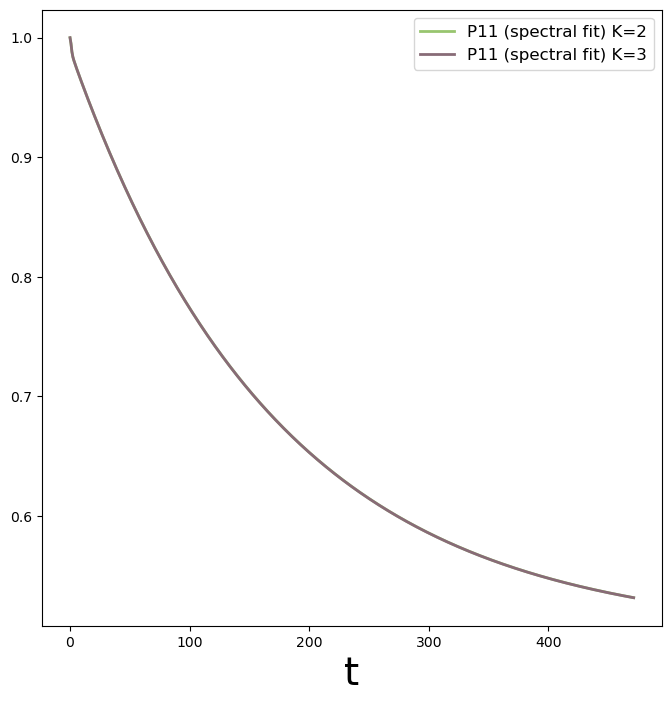

In [24]:
# generate results for different number of Matsubara terms per Lorentzian
# for max number of Lorentzians:

Nk_list = range(2, 4)
results_spectral_fit_nk = [
    generate_spectrum_results(obp, params_k[-1], Nk=Nk, max_depth=max_depth)
    for Nk in Nk_list
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) K={nk}",
    )
    for nk, result in zip(Nk_list, results_spectral_fit_nk)
]);

RHS construction time: 0.010676383972167969
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.67s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.68s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.68s / Remaining 00:00:00:00

 Total run time:   0.68s
ODE solver time: 0.6848409175872803


RHS construction time: 0.039350271224975586

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.07s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.13s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.60s / Remaining 00:00:00:00

 Total run time:   1.60s
ODE solver time: 1.604719638824463


RHS construction time: 0.13759541511535645

 [          0%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.11s / Remaining 00:00:00:11

 [          1%           ] Elapsed 0.13s / Remaining 00:00:00:12

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:15

 [          1%           ] Elapsed 0.17s / Remaining 00:00:00:16

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.20s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.21s / Remaining 00:00:00:10

 [          2%           ] Elapsed 0.22s / Remaining 00:00:00:10

 [*         3%           ] Elapsed 0.23s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.24s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.25s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.25s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.26s / Remaining 00:00:00:08

 [*         3%           ] Elapsed 0.27s / Remaining 00:00:00:08

 [*         4%           ] Elapsed 0.28s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.29s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.30s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.31s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.32s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.32s / Remaining 00:00:00:07

 [*         5%           ] Elapsed 0.33s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.34s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.35s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.36s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.37s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.37s / Remaining 00:00:00:07

 [*         6%           ] Elapsed 0.38s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.39s / Remaining 00:00:00:06

 [*         6%           ] Elapsed 0.40s / Remaining 00:00:00:06

 [*         6%           ] Elapsed 0.41s / Remaining 00:00:00:06

 [*         6%           ] Elapsed 0.42s / Remaining 00:00:00:06

 [*         6%           ] Elapsed 0.43s / Remaining 00:00:00:06

 [**        7%           ] Elapsed 0.43s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.44s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.45s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.46s / Remaining 00:00:00:06

 [**        7%           ] Elapsed 0.47s / Remaining 00:00:00:06

 [**        7%           ] Elapsed 0.48s / Remaining 00:00:00:06

 [**        8%           ] Elapsed 0.49s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.49s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.50s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.51s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.52s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.53s / Remaining 00:00:00:06

 [**        9%           ] Elapsed 0.54s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.55s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.56s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.56s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.57s / Remaining 00:00:00:05

 [**        9%           ] Elapsed 0.58s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.59s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.60s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.61s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.62s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.62s / Remaining 00:00:00:05

 [**       10%           ] Elapsed 0.63s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.64s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.65s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.66s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.67s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.68s / Remaining 00:00:00:05

 [***      11%           ] Elapsed 0.69s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.69s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.70s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.71s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.72s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.73s / Remaining 00:00:00:05

 [***      12%           ] Elapsed 0.74s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.75s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.75s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.76s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.77s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.78s / Remaining 00:00:00:05

 [***      13%           ] Elapsed 0.79s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.80s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.80s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.81s / Remaining 00:00:00:04

 [***      14%           ] Elapsed 0.82s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.83s / Remaining 00:00:00:05

 [***      14%           ] Elapsed 0.84s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.85s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.86s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.87s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.88s / Remaining 00:00:00:04

 [***      15%           ] Elapsed 0.88s / Remaining 00:00:00:05

 [***      15%           ] Elapsed 0.89s / Remaining 00:00:00:05

 [****     16%           ] Elapsed 0.90s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.91s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.92s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.93s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.94s / Remaining 00:00:00:04

 [****     16%           ] Elapsed 0.94s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.95s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.96s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.97s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.98s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 0.99s / Remaining 00:00:00:04

 [****     17%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.00s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.01s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.02s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.03s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.04s / Remaining 00:00:00:04

 [****     18%           ] Elapsed 1.05s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.06s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.06s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.07s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.08s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.09s / Remaining 00:00:00:04

 [****     19%           ] Elapsed 1.10s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.11s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.12s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.12s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.13s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.14s / Remaining 00:00:00:04

 [*****    20%           ] Elapsed 1.15s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.16s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.17s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.18s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.18s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.19s / Remaining 00:00:00:04

 [*****    21%           ] Elapsed 1.20s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.21s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.22s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.23s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.24s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.25s / Remaining 00:00:00:04

 [*****    22%           ] Elapsed 1.25s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.26s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.27s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.28s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.29s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.30s / Remaining 00:00:00:04

 [*****    23%           ] Elapsed 1.31s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.32s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.32s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.33s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.34s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.35s / Remaining 00:00:00:04

 [******   24%           ] Elapsed 1.36s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.37s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.38s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.38s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.39s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.40s / Remaining 00:00:00:04

 [******   25%           ] Elapsed 1.41s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.42s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.43s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.44s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.45s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.45s / Remaining 00:00:00:04

 [******   26%           ] Elapsed 1.46s / Remaining 00:00:00:04

 [******   27%           ] Elapsed 1.47s / Remaining 00:00:00:03

 [******   27%           ] Elapsed 1.48s / Remaining 00:00:00:04

 [******   27%           ] Elapsed 1.49s / Remaining 00:00:00:04

 [******   27%           ] Elapsed 1.50s / Remaining 00:00:00:04

 [******   27%           ] Elapsed 1.51s / Remaining 00:00:00:04

 [******   27%           ] Elapsed 1.52s / Remaining 00:00:00:04

 [******   28%           ] Elapsed 1.52s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.53s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.54s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.55s / Remaining 00:00:00:03

 [******   28%           ] Elapsed 1.56s / Remaining 00:00:00:04

 [******   28%           ] Elapsed 1.57s / Remaining 00:00:00:04

 [*******  29%           ] Elapsed 1.58s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.59s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.60s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.60s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.61s / Remaining 00:00:00:03

 [*******  29%           ] Elapsed 1.62s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.63s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.64s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.65s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.66s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.66s / Remaining 00:00:00:03

 [*******  30%           ] Elapsed 1.67s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.68s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.69s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.70s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.71s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.71s / Remaining 00:00:00:03

 [*******  31%           ] Elapsed 1.72s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.73s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.74s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.75s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.76s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.77s / Remaining 00:00:00:03

 [*******  32%           ] Elapsed 1.77s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.78s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.79s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.80s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.81s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.82s / Remaining 00:00:00:03

 [******** 33%           ] Elapsed 1.83s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.83s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.84s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.85s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.86s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.87s / Remaining 00:00:00:03

 [******** 34%           ] Elapsed 1.88s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.89s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.89s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.90s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.91s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.92s / Remaining 00:00:00:03

 [******** 35%           ] Elapsed 1.93s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.94s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.94s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.95s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.96s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.97s / Remaining 00:00:00:03

 [******** 36%           ] Elapsed 1.98s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 1.99s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 2.00s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 2.01s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 2.02s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 2.02s / Remaining 00:00:00:03

 [*********37%           ] Elapsed 2.03s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.04s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.05s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.06s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.07s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.07s / Remaining 00:00:00:03

 [*********38%           ] Elapsed 2.08s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.09s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.10s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.11s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.12s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.13s / Remaining 00:00:00:03

 [*********39%           ] Elapsed 2.14s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.14s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.15s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.16s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.17s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.18s / Remaining 00:00:00:03

 [*********40%           ] Elapsed 2.19s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.20s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.21s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.21s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.22s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.23s / Remaining 00:00:00:03

 [*********41%           ] Elapsed 2.24s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.25s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.26s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.27s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.28s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.29s / Remaining 00:00:00:03

 [*********42%           ] Elapsed 2.29s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.30s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.31s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.32s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.33s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.34s / Remaining 00:00:00:03

 [*********43%           ] Elapsed 2.35s / Remaining 00:00:00:03

 [*********44%           ] Elapsed 2.35s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 2.36s / Remaining 00:00:00:03

 [*********44%           ] Elapsed 2.37s / Remaining 00:00:00:03

 [*********44%           ] Elapsed 2.38s / Remaining 00:00:00:03

 [*********44%           ] Elapsed 2.39s / Remaining 00:00:00:03

 [*********44%           ] Elapsed 2.40s / Remaining 00:00:00:03

 [*********45%           ] Elapsed 2.41s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.42s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.43s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.43s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.44s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 2.45s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.46s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.47s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.48s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.49s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.50s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 2.50s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.51s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.52s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.53s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.54s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.55s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 2.56s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.57s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.57s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.58s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.59s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.60s / Remaining 00:00:00:02

 [*********48%           ] Elapsed 2.61s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.62s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.63s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.63s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.64s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.65s / Remaining 00:00:00:02

 [*********49%           ] Elapsed 2.66s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.67s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.68s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.69s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.70s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.70s / Remaining 00:00:00:02

 [*********50%           ] Elapsed 2.71s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.72s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.73s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.74s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.75s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.76s / Remaining 00:00:00:02

 [*********51%           ] Elapsed 2.77s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.78s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.79s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.79s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.80s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.81s / Remaining 00:00:00:02

 [*********52%           ] Elapsed 2.82s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.83s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.84s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.85s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.86s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.86s / Remaining 00:00:00:02

 [*********53%           ] Elapsed 2.87s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.88s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.89s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.90s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.91s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.92s / Remaining 00:00:00:02

 [*********54%           ] Elapsed 2.93s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.93s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.94s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.95s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.96s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.97s / Remaining 00:00:00:02

 [*********55%*          ] Elapsed 2.98s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.99s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 2.99s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 3.00s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 3.01s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 3.02s / Remaining 00:00:00:02

 [*********56%*          ] Elapsed 3.03s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.04s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.05s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.06s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.06s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.07s / Remaining 00:00:00:02

 [*********57%*          ] Elapsed 3.08s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.09s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.10s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.11s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.12s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.13s / Remaining 00:00:00:02

 [*********58%*          ] Elapsed 3.14s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.14s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.15s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.16s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.17s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.18s / Remaining 00:00:00:02

 [*********59%**         ] Elapsed 3.19s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.20s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.21s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.21s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.22s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.23s / Remaining 00:00:00:02

 [*********60%**         ] Elapsed 3.24s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.25s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.26s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.27s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.28s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.29s / Remaining 00:00:00:02

 [*********61%**         ] Elapsed 3.30s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.31s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.32s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.32s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.33s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.34s / Remaining 00:00:00:02

 [*********62%**         ] Elapsed 3.35s / Remaining 00:00:00:02

 [*********63%**         ] Elapsed 3.36s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 3.37s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 3.38s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 3.39s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 3.40s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 3.41s / Remaining 00:00:00:02

 [*********64%***        ] Elapsed 3.42s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.43s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.44s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.45s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.46s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 3.47s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.48s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.49s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.50s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.51s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.52s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 3.53s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.54s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.55s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.56s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.57s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.58s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 3.59s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.59s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.60s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.61s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.62s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.63s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 3.64s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.65s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.66s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.67s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.68s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.69s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 3.70s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.71s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.72s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.73s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.74s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.75s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 3.75s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.76s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.77s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.78s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.79s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.80s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 3.81s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.81s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.82s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.83s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.84s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.85s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 3.86s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.87s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.87s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.88s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.89s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.90s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 3.91s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.92s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.93s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.94s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.94s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.95s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 3.96s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.97s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.98s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 3.99s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 4.00s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 4.00s / Remaining 00:00:00:01

 [*********74%*****      ] Elapsed 4.01s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.02s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.03s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.04s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.05s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.06s / Remaining 00:00:00:01

 [*********75%*****      ] Elapsed 4.06s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.07s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.08s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.09s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.10s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.11s / Remaining 00:00:00:01

 [*********76%*****      ] Elapsed 4.11s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.12s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.13s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.14s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.15s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.16s / Remaining 00:00:00:01

 [*********77%******     ] Elapsed 4.17s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.18s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.18s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.19s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.20s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.21s / Remaining 00:00:00:01

 [*********78%******     ] Elapsed 4.22s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.23s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.23s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.24s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.25s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.26s / Remaining 00:00:00:01

 [*********79%******     ] Elapsed 4.27s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.28s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.29s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.29s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.30s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.31s / Remaining 00:00:00:01

 [*********80%******     ] Elapsed 4.32s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.33s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.34s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.35s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.35s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.36s / Remaining 00:00:00:01

 [*********81%*******    ] Elapsed 4.37s / Remaining 00:00:00:01

 [*********82%*******    ] Elapsed 4.38s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 4.39s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 4.40s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 4.41s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 4.41s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 4.42s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.43s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.44s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.45s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.46s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.47s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 4.47s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.48s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.49s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.52s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 4.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.53s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.54s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.55s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 4.58s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.60s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.60s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.61s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.62s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 4.63s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.67s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 4.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.70s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 4.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.74s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.75s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.76s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 4.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.81s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.82s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.83s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 4.84s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.85s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.86s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.87s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.88s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 4.89s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.91s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.91s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.92s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.93s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 4.94s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.95s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.96s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.97s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.97s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.98s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 4.99s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.00s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.01s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.02s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.02s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.03s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 5.04s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.05s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.06s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.07s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.08s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.09s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 5.09s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.10s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.11s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.12s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.14s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 5.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.16s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.17s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.18s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.19s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 5.20s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.21s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.21s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.22s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.23s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.24s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 5.25s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.26s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.27s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 5.30s / Remaining 00:00:00:00

 [********100%***********] Elapsed 5.31s / Remaining 00:00:00:00

 [********100%***********] Elapsed 5.32s / Remaining 00:00:00:00

 [********100%***********] Elapsed 5.33s / Remaining 00:00:00:00

 Total run time:   5.33s
ODE solver time: 5.331688404083252


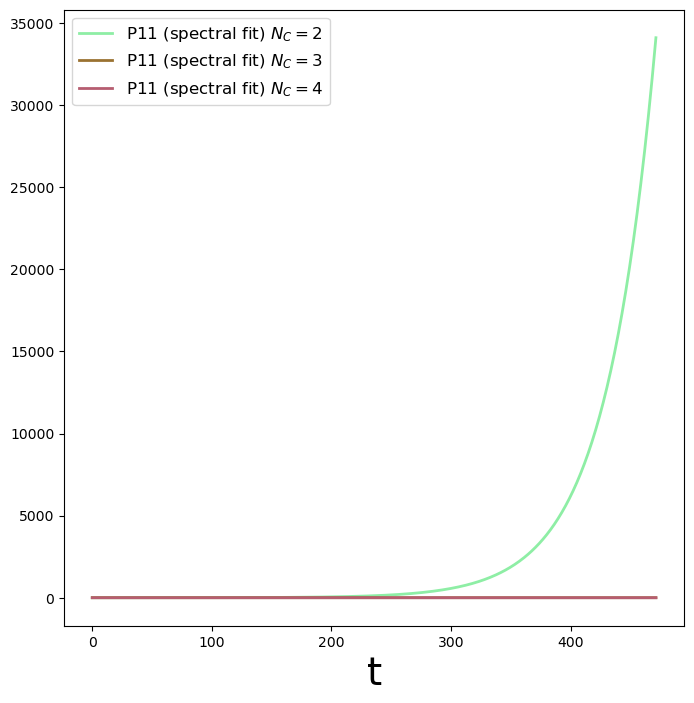

In [25]:
# Generate results for different depths:

Nc_list = range(2, max_depth)
results_spectral_fit_nc = [
    generate_spectrum_results(obp, params_k[-1], Nk=1, max_depth=Nc)
    for Nc in Nc_list
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) $N_C={nc}$",
    )
    for nc, result in zip(Nc_list, results_spectral_fit_nc)
]);

We now combine the fitting and correlation function data into one large plot.

In [26]:
def correlation_approx_matsubara(t, ck, vk):
    """ Calculate the approximate real or imaginary part of the
        correlation function from the matsubara expansion co-efficients.
    """
    ck = np.array(ck)
    vk = np.array(vk)
    return np.sum(ck[:, None] * np.exp(-vk[:, None] * t), axis=0)

In [27]:
def plot_cr_fit_vs_actual(t, ckAR, vkAR, C, axes):
    """ Plot the C_R(t) fit. """
    yR = correlation_approx_matsubara(t, ckAR, vkAR)

    axes.plot(
        t, np.real(C),
        "r", linewidth=3, label="Original",
    )
    axes.plot(
        t, np.real(yR),
        "g", dashes=[3, 3], linewidth=2, label="Reconstructed",
    )

    axes.legend(loc=0)
    axes.set_ylabel(r'$C_R(t)$', fontsize=28)
    axes.set_xlabel(r'$t\;\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(0.15, 0.85, "(a)", fontsize=28, transform=axes.transAxes)


def plot_ci_fit_vs_actual(t, ckAI, vkAI, C, axes):
    """ Plot the C_I(t) fit. """
    yI = correlation_approx_matsubara(t, ckAI, vkAI)

    axes.plot(
        t, np.imag(C),
        "r", linewidth=3, label="Original",
    )
    axes.plot(
        t, np.real(yI),
        "g", dashes=[3, 3], linewidth=2, label="Reconstructed",
    )

    axes.legend(loc=0)
    axes.set_ylabel(r'$C_I(t)$', fontsize=28)
    axes.set_xlabel(r'$t\;\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(0.80, 0.80, "(b)", fontsize=28, transform=axes.transAxes)


def plot_jw_fit_vs_actual(bath_fit, obp, axes):
    """ Plot the J(w) fit. """
    [lam, gamma, w0] = bath_fit
    [alpha, wc] = [obp.alpha, obp.wc]

    w = np.linspace(0, 25, 20000)

    J_orig = ohmic_spectral_density(w, alpha=alpha, wc=wc)
    J_fit = spectral_density_approx(w, lam, gamma, w0)

    axes.plot(
        w, J_orig,
        "r", linewidth=3, label=r"$J(\omega)$ original",
    )
    axes.plot(
        w, J_fit,
        "g", dashes=[3, 3], linewidth=2, label=r"$J(\omega)$ Fit $k_J = 4$",
    )

    axes.legend(loc=0)
    axes.set_ylabel(r'$J(\omega)$', fontsize=28)
    axes.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(0.15, 0.85, "(c)", fontsize=28, transform=axes.transAxes)


def plot_sw_fit_vs_actual(bath_fit, obp, axes):
    """ Plot the S(w) fit. """
    [lam, gamma, w0] = bath_fit
    [alpha, wc, beta] = [obp.alpha, obp.wc, obp.beta]

    # avoid the pole in the fit around zero:
    w = np.concatenate(
        [np.linspace(-10, -0.1, 5000),
         np.linspace(0.1, 10, 5000)],
    )

    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = (
        spectral_density_approx(w, lam, gamma, w0) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

    axes.plot(w, s_orig, "r", linewidth=3, label="Original")
    axes.plot(w, s_fit, "g", dashes=[3, 3], linewidth=2, label="Reconstructed")

    axes.legend()
    axes.set_ylabel(r'$S(\omega)$', fontsize=28)
    axes.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(0.15, 0.85, "(d)", fontsize=28, transform=axes.transAxes)


def plot_matsubara_spectrum_fit_vs_actual(
    t, C, matsubara_fit, bath_fit, obp,
):
    """ Plot the Matsubara fit of the spectrum . """
    fig = plt.figure(figsize=(12, 10))
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

    [ckAR, vkAR, ckAI, vkAI] = matsubara_fit

    plot_cr_fit_vs_actual(
        t, ckAR, vkAR, C,
        axes=fig.add_subplot(grid[0, 0]),
    )
    plot_ci_fit_vs_actual(
        t, ckAI, vkAI, C,
        axes=fig.add_subplot(grid[0, 1]),
    )
    plot_jw_fit_vs_actual(
        bath_fit, obp,
        axes=fig.add_subplot(grid[1, 0]),
    )
    plot_sw_fit_vs_actual(
        bath_fit, obp,
        axes=fig.add_subplot(grid[1, 1]),
    )

    return fig

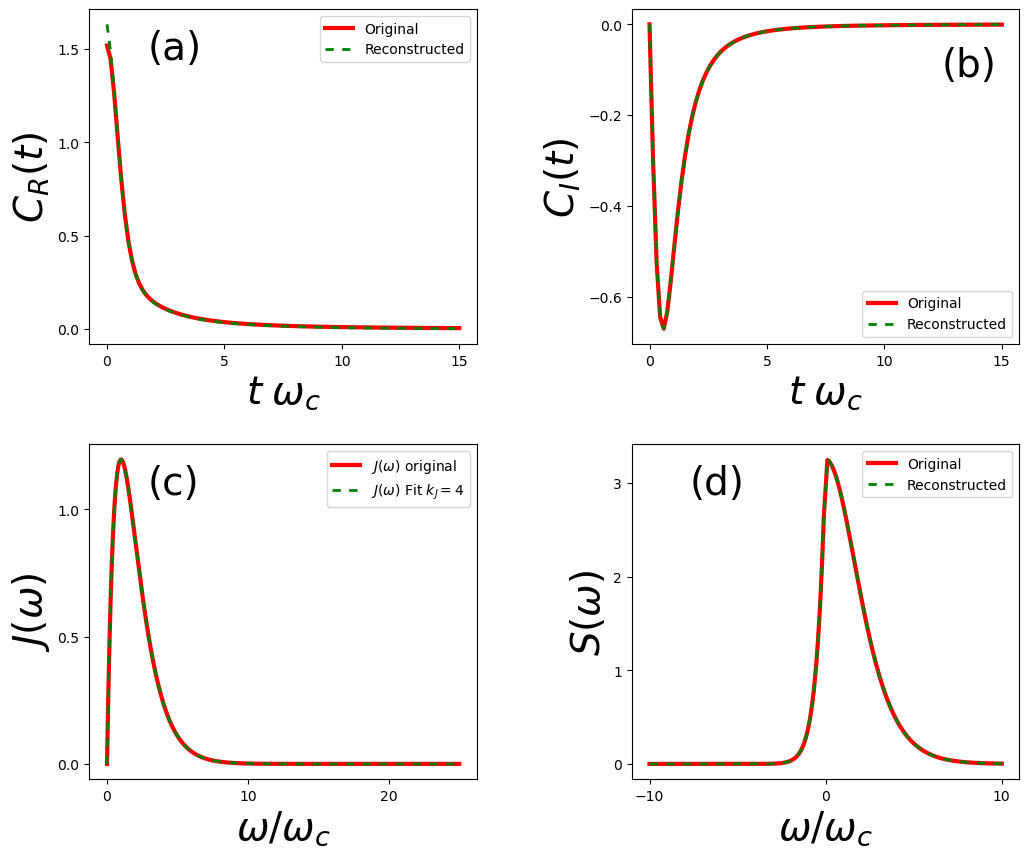

In [28]:
t = np.linspace(0, 15, 100)
C = ohmic_correlation(t, alpha=obp.alpha, wc=obp.wc, beta=obp.beta)

ckAR, vkAR, ckAI, vkAI, terminator = (
    matsubara_coefficients_from_spectral_fit(
        lam, gamma, w0, beta=obp.beta, Q=obp.Q, Nk=1,
    )
)

matsubara_fit = [ckAR, vkAR, ckAI, vkAI]
bath_fit = [lam, gamma, w0]

plot_matsubara_spectrum_fit_vs_actual(
    t, C, matsubara_fit,
    bath_fit, obp,
);

## Building the HEOM bath by fitting the correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

Here we fit the real and imaginary parts seperately, using the following ansatz

$$C_R^F(t) = \sum_{i=1}^{k_R} c_R^ie^{-\gamma_R^i t}\cos(\omega_R^i t)$$

$$C_I^F(t) = \sum_{i=1}^{k_I} c_I^ie^{-\gamma_I^i t}\sin(\omega_I^i t)$$

In [29]:
# The approximate correlation functions and a helper for fitting
# the approximate correlation function to values calculated from
# the analytical formula:

def correlation_approx_real(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return np.sum(
        a[:, None] * np.exp(b[:, None] * t) * np.cos(c[:, None] * t),
        axis=0,
    )


def correlation_approx_imag(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return np.sum(
        a[:, None] * np.exp(b[:, None] * t) * np.sin(c[:, None] * t),
        axis=0,
    )


def fit_correlation_real(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.1] * len(t)

    C_max = abs(max(C, key=abs))

    guesses = pack([C_max] * N, [-wc] * N, [wc] * N)
    lower_bounds = pack([-20 * C_max] * N, [-np.inf] * N, [0.] * N)
    upper_bounds = pack([20 * C_max] * N, [0.1] * N, [np.inf] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_real(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)


def fit_correlation_imag(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.0001] * len(t)

    C_max = abs(max(C, key=abs))

    guesses = pack([-C_max] * N, [-2] * N, [1] * N)
    lower_bounds = pack([-5 * C_max] * N, [-100] * N, [0.] * N)
    upper_bounds = pack([5 * C_max] * N, [0.01] * N, [100] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_imag(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)

In [30]:
t = np.linspace(0, 15, 15000)
C = ohmic_correlation(t, alpha=obp.alpha, wc=obp.wc, beta=obp.beta)

params_k_real = [
    fit_correlation_real(np.real(C), t, wc=obp.wc, N=i+1)
    for i in range(3)
]

params_k_imag = [
    fit_correlation_imag(np.imag(C), t, wc=obp.wc, N=i+1)
    for i in range(3)
]

Parameters [k=0]: lam=[1.72456692]; gamma=[-1.29280164]; w0=[1.23435658e-12]


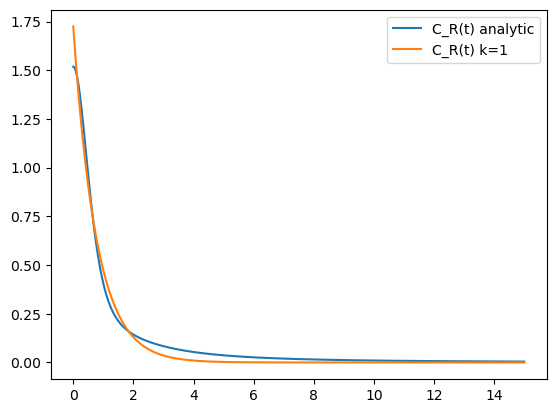

Parameters [k=1]: lam=[0.73278016 0.93976586]; gamma=[-0.63185142 -1.192904  ]; w0=[6.0550398e-21 1.4062511e+00]


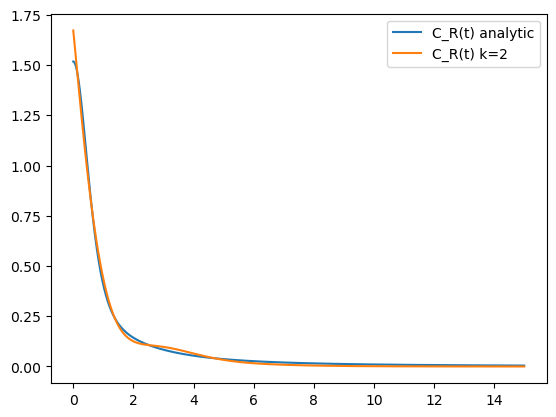

Parameters [k=2]: lam=[ 2.24463736  0.22291178 -0.93873415]; gamma=[-2.2178005  -0.34248562 -4.92644025]; w0=[1.26699936e-11 1.43128018e-20 3.87910289e+00]


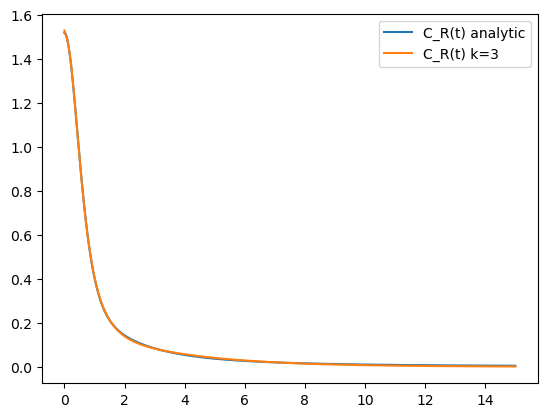

In [31]:
for k, params in enumerate(params_k_real):
    lam, gamma, w0 = params
    y = correlation_approx_real(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.real(C), label="C_R(t) analytic")
    plt.plot(t, y, label=f"C_R(t) k={k + 1}")
    plt.legend()
    plt.show()

Parameters [k=0]: lam=[-3.35965972]; gamma=[-1.52063694]; w0=[0.80990586]


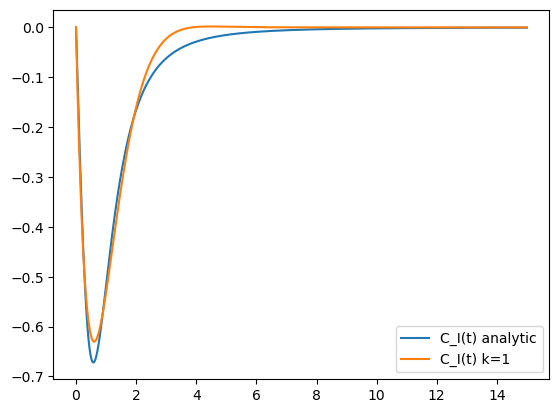

Parameters [k=1]: lam=[-0.98439901 -3.35965972]; gamma=[-1.45054573 -1.16604136]; w0=[1.77999542 0.29085036]


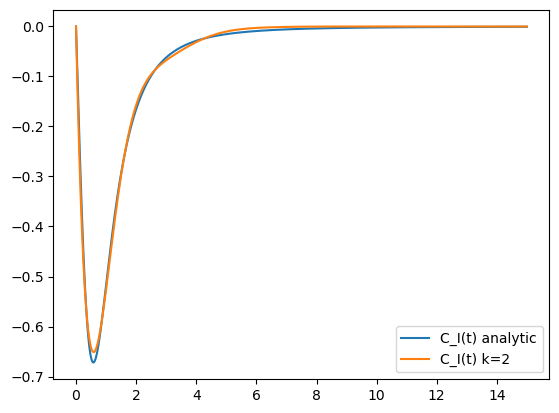

Parameters [k=2]: lam=[-3.31708489 -0.3074955  -0.85913953]; gamma=[-0.99597103 -1.1862755  -1.09310649]; w0=[0.16634264 2.69673959 1.36912301]


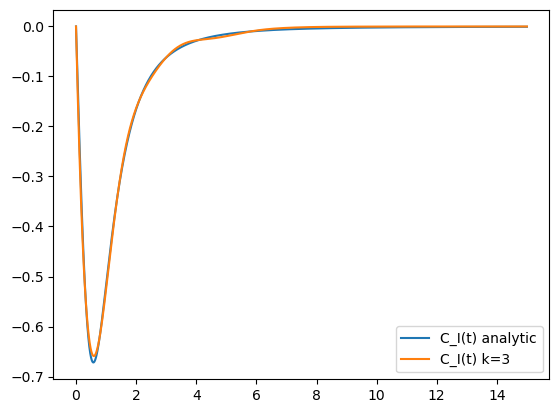

In [32]:
for k, params in enumerate(params_k_imag):
    lam, gamma, w0 = params
    y = correlation_approx_imag(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.imag(C), label="C_I(t) analytic")
    plt.plot(t, y, label=f"C_I(t) k={k + 1}")
    plt.legend()
    plt.show()

Now we construct the `BosonicBath` co-efficients and frequencies from the fit to the correlation function:

In [33]:
def matsubara_coefficients_from_corr_fit_real(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part
        of the correlation function.
    """
    ckAR = [0.5 * x + 0j for x in lam]  # the 0.5 is from the cosine
    # extend the list with the complex conjugates:
    ckAR.extend(np.conjugate(ckAR))

    vkAR = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAR.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])

    return ckAR, vkAR


def matsubara_coefficients_from_corr_fit_imag(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part
        of the correlation function.
    """
    ckAI = [-0.5j * x for x in lam]  # the 0.5 is from the sine
    # extend the list with the complex conjugates:
    ckAI.extend(np.conjugate(ckAI))

    vkAI = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAI.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])

    return ckAI, vkAI

In [34]:
ckAR, vkAR = matsubara_coefficients_from_corr_fit_real(*params_k_real[-1])
ckAI, vkAI = matsubara_coefficients_from_corr_fit_imag(*params_k_imag[-1])

In [35]:
def corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI):
    """ Calculates the approximate power spectrum from ck and vk. """
    S = np.zeros(len(w), dtype=np.complex128)
    for ck, vk in zip(ckAR, vkAR):
        S += (
            2 * ck * np.real(vk) /
            ((w - np.imag(vk))**2 + (np.real(vk)**2))
        )
    for ck, vk in zip(ckAI, vkAI):
        S += (
            2 * 1.0j * ck * np.real(vk) /
            ((w - np.imag(vk))**2 + (np.real(vk)**2))
        )
    return S

In [36]:
def plot_jw_correlation_fit_vs_actual(matsubara_fit, obp, axes):
    """ Plot J(w) from the correlation fit. """
    [ckAR, vkAR, ckAI, vkAI] = matsubara_fit
    [alpha, wc] = [obp.alpha, obp.wc]

    w = np.linspace(0.001, 25, 20000)

    J_orig = ohmic_spectral_density(w, alpha=alpha, wc=wc)
    J_fit = np.real(
        corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI) /
        (((1 / (np.e**(w * obp.beta) - 1)) + 1) * 2)
    )

    axes.plot(
        w, J_orig,
        "r", linewidth=3, label=r"$J(\omega)$ original",
    )
    axes.plot(
        w, J_fit,
        "g", dashes=[3, 3], linewidth=2, label=r"$J(\omega)$ fit",
    )

    axes.legend(loc=0)
    axes.set_ylabel(r'$J(\omega)$', fontsize=28)
    axes.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(3, 1.1, "(c)", fontsize=28)


def plot_sw_correlation_fit_vs_actual(matsubara_fit, obp, axes):
    """ Plot S(W) from the correlation fit. """
    [ckAR, vkAR, ckAI, vkAI] = matsubara_fit
    [alpha, wc, beta] = [obp.alpha, obp.wc, obp.beta]

    # avoid the pole in the fit around zero:
    w = np.concatenate([
        np.linspace(-10, -0.1, 5000),
        np.linspace(0.1, 10, 5000),
    ])

    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = corr_spectrum_approx(w, ckAR, vkAR, ckAI, vkAI)

    axes.plot(
        w, s_orig,
        "r", linewidth=3, label="Original",
    )
    axes.plot(
        w, s_fit,
        "g", dashes=[3, 3], linewidth=2, label="Reconstructed",
    )

    axes.legend()
    axes.set_ylabel(r'$S(\omega)$', fontsize=28)
    axes.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
    axes.locator_params(axis='y', nbins=4)
    axes.locator_params(axis='x', nbins=4)
    axes.text(0.15, 0.85, "(d)", fontsize=28, transform=axes.transAxes)


def plot_matsubara_correlation_fit_vs_actual(t, C, matsubara_fit, obp):
    fig = plt.figure(figsize=(12, 10))
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

    ckAR, vkAR, ckAI, vkAI = matsubara_fit

    plot_cr_fit_vs_actual(
        t, ckAR, vkAR, C,
        axes=fig.add_subplot(grid[0, 0]),
    )
    plot_ci_fit_vs_actual(
        t, ckAI, vkAI, C,
        axes=fig.add_subplot(grid[0, 1]),
    )
    plot_jw_correlation_fit_vs_actual(
        matsubara_fit, obp,
        axes=fig.add_subplot(grid[1, 0]),
    )
    plot_sw_correlation_fit_vs_actual(
        matsubara_fit, obp,
        axes=fig.add_subplot(grid[1, 1]),
    )

/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


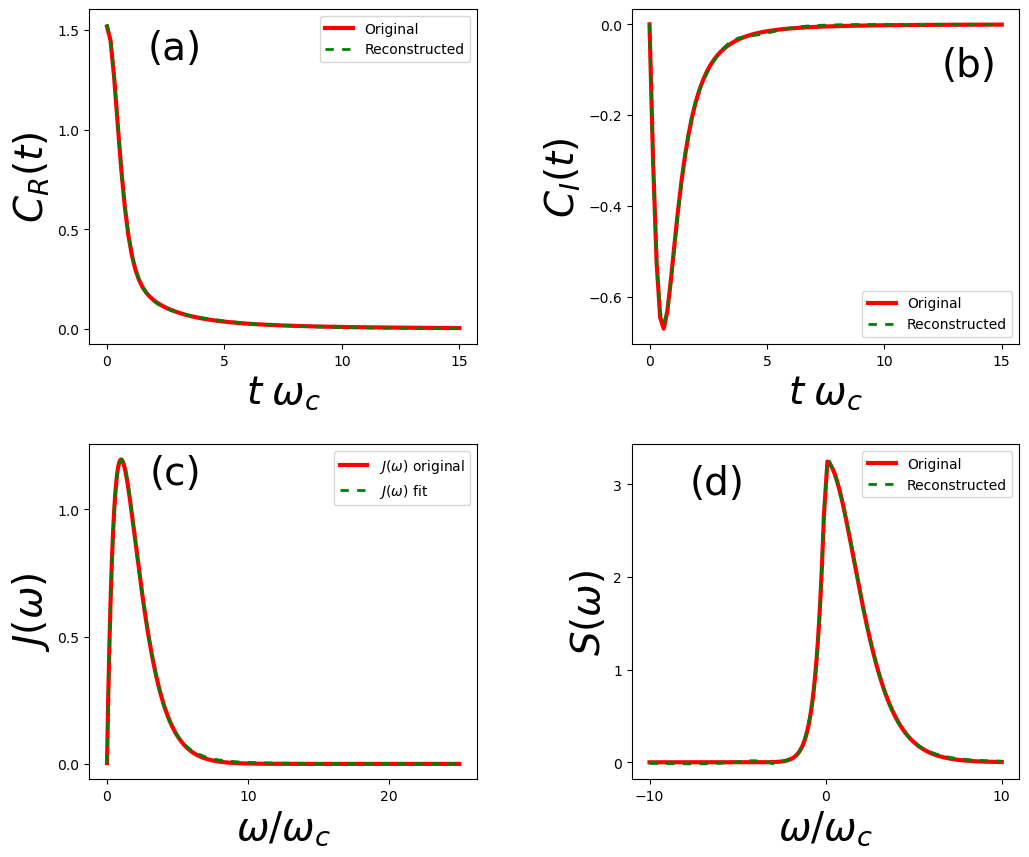

In [37]:
t = np.linspace(0, 15, 100)
C = ohmic_correlation(t, alpha=obp.alpha, wc=obp.wc, beta=obp.beta)

matsubara_fit = [ckAR, vkAR, ckAI, vkAI]

plot_matsubara_correlation_fit_vs_actual(
    t, C, matsubara_fit, obp,
)

In [38]:
def generate_corr_results(params_real, params_imag, max_depth):
    ckAR, vkAR = matsubara_coefficients_from_corr_fit_real(
        *params_real
    )
    ckAI, vkAI = matsubara_coefficients_from_corr_fit_imag(
        *params_imag
    )

    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    with timer("RHS construction time"):
        bath = BosonicBath(obp.Q, ckAR, vkAR, ckAI, vkAI)
        HEOM_corr_fit = HEOMSolver(
            Hsys, bath, max_depth=max_depth, options=options,
        )

    with timer("ODE solver time"):
        results_corr_fit = (HEOM_corr_fit.run(rho0, tlist))

    return results_corr_fit


# Generate results for different number of lorentzians in fit:
results_corr_fit_pk = [
    print(f"{pk + 1}") or generate_corr_results(
        params_real, params_imag, max_depth=max_depth,
    )
    for pk, (params_real, params_imag)
    in enumerate(zip(params_k_real, params_k_imag))
]

1
RHS construction time: 0.00903010368347168
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.74s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.76s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.76s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.76s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.76s / Remaining 00:00:00:00

 Total run time:   0.76s
ODE solver time: 0.7602365016937256
2


RHS construction time: 0.13899779319763184

 [          0%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.10s / Remaining 00:00:00:10

 [          1%           ] Elapsed 0.12s / Remaining 00:00:00:11

 [          1%           ] Elapsed 0.13s / Remaining 00:00:00:12

 [          1%           ] Elapsed 0.14s / Remaining 00:00:00:13

 [          1%           ] Elapsed 0.15s / Remaining 00:00:00:14

 [          1%           ] Elapsed 0.16s / Remaining 00:00:00:15

 [          2%           ] Elapsed 0.17s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.18s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.20s / Remaining 00:00:00:09

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.22s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.22s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.23s / Remaining 00:00:00:07

 [*         4%           ] Elapsed 0.23s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.24s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.24s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.25s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.25s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.26s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.26s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.27s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.27s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.28s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.28s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.29s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.29s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.30s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.30s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.31s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.31s / Remaining 00:00:00:04

 [*         6%           ] Elapsed 0.32s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.32s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.33s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.33s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.34s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.34s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.35s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.36s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.36s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.36s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.37s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.38s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.38s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.40s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.40s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.41s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.41s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.42s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.45s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.45s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.46s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.47s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.47s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.49s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.53s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.56s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.56s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.57s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.57s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.60s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.60s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.61s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.61s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.63s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.64s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.64s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.65s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.65s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.66s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.67s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.67s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.68s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.68s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.70s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.73s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.74s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.74s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.75s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.75s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.76s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.76s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.77s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.78s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.78s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.79s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.80s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.81s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.81s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.82s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.85s / Remaining 00:00:00:03

 [*****    23%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.06s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.06s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.07s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.07s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.10s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.10s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.11s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.11s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.23s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.23s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.25s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.25s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.27s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.27s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.28s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.28s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.29s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.31s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.31s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.32s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.35s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.38s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.41s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.44s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.47s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.47s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.48s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.48s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.52s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.52s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.55s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.10s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.11s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.11s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.15s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.15s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.16s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.16s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.20s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.20s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.30s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.30s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.33s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.33s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.35s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.45s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.45s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.52s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.11s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.11s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.13s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.14s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.17s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.17s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.18s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.18s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.19s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.20s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.20s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.25s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.25s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.26s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.26s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.27s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.27s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.28s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.28s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.29s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.30s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.31s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.31s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.32s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.32s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.33s / Remaining 00:00:00:00

 Total run time:   3.33s
ODE solver time: 3.3313138484954834
3


RHS construction time: 0.6389048099517822


 [          0%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.38s / Remaining 00:00:00:37

 [          1%           ] Elapsed 0.43s / Remaining 00:00:00:43

 [          1%           ] Elapsed 0.48s / Remaining 00:00:00:47

 [          1%           ] Elapsed 0.53s / Remaining 00:00:00:52

 [          1%           ] Elapsed 0.57s / Remaining 00:00:00:56

 [          1%           ] Elapsed 0.61s / Remaining 00:00:01:00

 [          2%           ] Elapsed 0.64s / Remaining 00:00:00:31

 [          2%           ] Elapsed 0.68s / Remaining 00:00:00:33

 [          2%           ] Elapsed 0.72s / Remaining 00:00:00:35

 [          2%           ] Elapsed 0.76s / Remaining 00:00:00:37

 [          2%           ] Elapsed 0.79s / Remaining 00:00:00:38

 [          2%           ] Elapsed 0.84s / Remaining 00:00:00:41

 [*         3%           ] Elapsed 0.88s / Remaining 00:00:00:28

 [*         3%           ] Elapsed 0.92s / Remaining 00:00:00:29

 [*         3%           ] Elapsed 0.97s / Remaining 00:00:00:31

 [*         3%           ] Elapsed 1.02s / Remaining 00:00:00:32

 [*         3%           ] Elapsed 1.05s / Remaining 00:00:00:34

 [*         3%           ] Elapsed 1.10s / Remaining 00:00:00:35

 [*         4%           ] Elapsed 1.15s / Remaining 00:00:00:27

 [*         4%           ] Elapsed 1.19s / Remaining 00:00:00:28

 [*         4%           ] Elapsed 1.23s / Remaining 00:00:00:29

 [*         4%           ] Elapsed 1.27s / Remaining 00:00:00:30

 [*         4%           ] Elapsed 1.32s / Remaining 00:00:00:31

 [*         4%           ] Elapsed 1.35s / Remaining 00:00:00:32

 [*         5%           ] Elapsed 1.39s / Remaining 00:00:00:26

 [*         5%           ] Elapsed 1.44s / Remaining 00:00:00:27

 [*         5%           ] Elapsed 1.48s / Remaining 00:00:00:28

 [*         5%           ] Elapsed 1.52s / Remaining 00:00:00:28

 [*         5%           ] Elapsed 1.57s / Remaining 00:00:00:29

 [*         5%           ] Elapsed 1.61s / Remaining 00:00:00:30

 [*         6%           ] Elapsed 1.66s / Remaining 00:00:00:25

 [*         6%           ] Elapsed 1.70s / Remaining 00:00:00:26

 [*         6%           ] Elapsed 1.75s / Remaining 00:00:00:27

 [*         6%           ] Elapsed 1.79s / Remaining 00:00:00:28

 [*         6%           ] Elapsed 1.84s / Remaining 00:00:00:28

 [*         6%           ] Elapsed 1.88s / Remaining 00:00:00:29

 [**        7%           ] Elapsed 1.92s / Remaining 00:00:00:25

 [**        7%           ] Elapsed 1.97s / Remaining 00:00:00:26

 [**        7%           ] Elapsed 2.01s / Remaining 00:00:00:26

 [**        7%           ] Elapsed 2.06s / Remaining 00:00:00:27

 [**        7%           ] Elapsed 2.10s / Remaining 00:00:00:27

 [**        7%           ] Elapsed 2.15s / Remaining 00:00:00:28

 [**        8%           ] Elapsed 2.19s / Remaining 00:00:00:25

 [**        8%           ] Elapsed 2.24s / Remaining 00:00:00:25

 [**        8%           ] Elapsed 2.28s / Remaining 00:00:00:26

 [**        8%           ] Elapsed 2.33s / Remaining 00:00:00:26

 [**        8%           ] Elapsed 2.37s / Remaining 00:00:00:27

 [**        8%           ] Elapsed 2.42s / Remaining 00:00:00:27

 [**        9%           ] Elapsed 2.47s / Remaining 00:00:00:24

 [**        9%           ] Elapsed 2.52s / Remaining 00:00:00:25

 [**        9%           ] Elapsed 2.56s / Remaining 00:00:00:25

 [**        9%           ] Elapsed 2.60s / Remaining 00:00:00:26

 [**        9%           ] Elapsed 2.66s / Remaining 00:00:00:26

 [**        9%           ] Elapsed 2.70s / Remaining 00:00:00:27

 [**       10%           ] Elapsed 2.75s / Remaining 00:00:00:24

 [**       10%           ] Elapsed 2.78s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.84s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.88s / Remaining 00:00:00:25

 [**       10%           ] Elapsed 2.93s / Remaining 00:00:00:26

 [**       10%           ] Elapsed 2.97s / Remaining 00:00:00:26

 [***      11%           ] Elapsed 3.02s / Remaining 00:00:00:24

 [***      11%           ] Elapsed 3.06s / Remaining 00:00:00:24

 [***      11%           ] Elapsed 3.11s / Remaining 00:00:00:25

 [***      11%           ] Elapsed 3.16s / Remaining 00:00:00:25

 [***      11%           ] Elapsed 3.21s / Remaining 00:00:00:25

 [***      11%           ] Elapsed 3.25s / Remaining 00:00:00:26

 [***      12%           ] Elapsed 3.30s / Remaining 00:00:00:24

 [***      12%           ] Elapsed 3.34s / Remaining 00:00:00:24

 [***      12%           ] Elapsed 3.39s / Remaining 00:00:00:24

 [***      12%           ] Elapsed 3.44s / Remaining 00:00:00:25

 [***      12%           ] Elapsed 3.48s / Remaining 00:00:00:25

 [***      12%           ] Elapsed 3.53s / Remaining 00:00:00:25

 [***      13%           ] Elapsed 3.58s / Remaining 00:00:00:23

 [***      13%           ] Elapsed 3.62s / Remaining 00:00:00:24

 [***      13%           ] Elapsed 3.66s / Remaining 00:00:00:24

 [***      13%           ] Elapsed 3.71s / Remaining 00:00:00:24

 [***      13%           ] Elapsed 3.75s / Remaining 00:00:00:25

 [***      13%           ] Elapsed 3.80s / Remaining 00:00:00:25

 [***      14%           ] Elapsed 3.84s / Remaining 00:00:00:23

 [***      14%           ] Elapsed 3.89s / Remaining 00:00:00:23

 [***      14%           ] Elapsed 3.93s / Remaining 00:00:00:24

 [***      14%           ] Elapsed 3.98s / Remaining 00:00:00:24

 [***      14%           ] Elapsed 4.03s / Remaining 00:00:00:24

 [***      14%           ] Elapsed 4.07s / Remaining 00:00:00:25

 [***      15%           ] Elapsed 4.11s / Remaining 00:00:00:23

 [***      15%           ] Elapsed 4.16s / Remaining 00:00:00:23

 [***      15%           ] Elapsed 4.21s / Remaining 00:00:00:23

 [***      15%           ] Elapsed 4.25s / Remaining 00:00:00:24

 [***      15%           ] Elapsed 4.30s / Remaining 00:00:00:24

 [***      15%           ] Elapsed 4.35s / Remaining 00:00:00:24

 [****     16%           ] Elapsed 4.39s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.43s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.48s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.52s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.57s / Remaining 00:00:00:23

 [****     16%           ] Elapsed 4.61s / Remaining 00:00:00:24

 [****     17%           ] Elapsed 4.66s / Remaining 00:00:00:22

 [****     17%           ] Elapsed 4.70s / Remaining 00:00:00:22

 [****     17%           ] Elapsed 4.75s / Remaining 00:00:00:23

 [****     17%           ] Elapsed 4.80s / Remaining 00:00:00:23

 [****     17%           ] Elapsed 4.84s / Remaining 00:00:00:23

 [****     17%           ] Elapsed 4.88s / Remaining 00:00:00:23

 [****     18%           ] Elapsed 4.93s / Remaining 00:00:00:22

 [****     18%           ] Elapsed 4.98s / Remaining 00:00:00:22

 [****     18%           ] Elapsed 5.02s / Remaining 00:00:00:22

 [****     18%           ] Elapsed 5.07s / Remaining 00:00:00:23

 [****     18%           ] Elapsed 5.12s / Remaining 00:00:00:23

 [****     18%           ] Elapsed 5.16s / Remaining 00:00:00:23

 [****     19%           ] Elapsed 5.21s / Remaining 00:00:00:22

 [****     19%           ] Elapsed 5.25s / Remaining 00:00:00:22

 [****     19%           ] Elapsed 5.30s / Remaining 00:00:00:22

 [****     19%           ] Elapsed 5.34s / Remaining 00:00:00:22

 [****     19%           ] Elapsed 5.39s / Remaining 00:00:00:22

 [****     19%           ] Elapsed 5.43s / Remaining 00:00:00:23

 [*****    20%           ] Elapsed 5.48s / Remaining 00:00:00:21

 [*****    20%           ] Elapsed 5.52s / Remaining 00:00:00:22

 [*****    20%           ] Elapsed 5.57s / Remaining 00:00:00:22

 [*****    20%           ] Elapsed 5.61s / Remaining 00:00:00:22

 [*****    20%           ] Elapsed 5.65s / Remaining 00:00:00:22

 [*****    20%           ] Elapsed 5.70s / Remaining 00:00:00:22

 [*****    21%           ] Elapsed 5.75s / Remaining 00:00:00:21

 [*****    21%           ] Elapsed 5.79s / Remaining 00:00:00:21

 [*****    21%           ] Elapsed 5.84s / Remaining 00:00:00:21

 [*****    21%           ] Elapsed 5.89s / Remaining 00:00:00:22

 [*****    21%           ] Elapsed 5.93s / Remaining 00:00:00:22

 [*****    21%           ] Elapsed 5.97s / Remaining 00:00:00:22

 [*****    22%           ] Elapsed 6.02s / Remaining 00:00:00:21

 [*****    22%           ] Elapsed 6.06s / Remaining 00:00:00:21

 [*****    22%           ] Elapsed 6.11s / Remaining 00:00:00:21

 [*****    22%           ] Elapsed 6.16s / Remaining 00:00:00:21

 [*****    22%           ] Elapsed 6.20s / Remaining 00:00:00:21

 [*****    22%           ] Elapsed 6.24s / Remaining 00:00:00:22

 [*****    23%           ] Elapsed 6.29s / Remaining 00:00:00:21

 [*****    23%           ] Elapsed 6.33s / Remaining 00:00:00:21

 [*****    23%           ] Elapsed 6.38s / Remaining 00:00:00:21

 [*****    23%           ] Elapsed 6.42s / Remaining 00:00:00:21

 [*****    23%           ] Elapsed 6.47s / Remaining 00:00:00:21

 [*****    23%           ] Elapsed 6.51s / Remaining 00:00:00:21

 [******   24%           ] Elapsed 6.56s / Remaining 00:00:00:20

 [******   24%           ] Elapsed 6.60s / Remaining 00:00:00:20

 [******   24%           ] Elapsed 6.65s / Remaining 00:00:00:21

 [******   24%           ] Elapsed 6.69s / Remaining 00:00:00:21

 [******   24%           ] Elapsed 6.73s / Remaining 00:00:00:21

 [******   24%           ] Elapsed 6.77s / Remaining 00:00:00:21

 [******   25%           ] Elapsed 6.81s / Remaining 00:00:00:20

 [******   25%           ] Elapsed 6.85s / Remaining 00:00:00:20

 [******   25%           ] Elapsed 6.90s / Remaining 00:00:00:20

 [******   25%           ] Elapsed 6.94s / Remaining 00:00:00:20

 [******   25%           ] Elapsed 6.97s / Remaining 00:00:00:20

 [******   25%           ] Elapsed 7.02s / Remaining 00:00:00:21

 [******   26%           ] Elapsed 7.06s / Remaining 00:00:00:20

 [******   26%           ] Elapsed 7.10s / Remaining 00:00:00:20

 [******   26%           ] Elapsed 7.15s / Remaining 00:00:00:20

 [******   26%           ] Elapsed 7.18s / Remaining 00:00:00:20

 [******   26%           ] Elapsed 7.22s / Remaining 00:00:00:20

 [******   26%           ] Elapsed 7.27s / Remaining 00:00:00:20

 [******   27%           ] Elapsed 7.30s / Remaining 00:00:00:19

 [******   27%           ] Elapsed 7.36s / Remaining 00:00:00:19

 [******   27%           ] Elapsed 7.40s / Remaining 00:00:00:20

 [******   27%           ] Elapsed 7.44s / Remaining 00:00:00:20

 [******   27%           ] Elapsed 7.49s / Remaining 00:00:00:20

 [******   27%           ] Elapsed 7.54s / Remaining 00:00:00:20

 [******   28%           ] Elapsed 7.58s / Remaining 00:00:00:19

 [******   28%           ] Elapsed 7.63s / Remaining 00:00:00:19

 [******   28%           ] Elapsed 7.67s / Remaining 00:00:00:19

 [******   28%           ] Elapsed 7.72s / Remaining 00:00:00:19

 [******   28%           ] Elapsed 7.76s / Remaining 00:00:00:19

 [******   28%           ] Elapsed 7.81s / Remaining 00:00:00:20

 [*******  29%           ] Elapsed 7.85s / Remaining 00:00:00:19

 [*******  29%           ] Elapsed 7.90s / Remaining 00:00:00:19

 [*******  29%           ] Elapsed 7.94s / Remaining 00:00:00:19

 [*******  29%           ] Elapsed 7.99s / Remaining 00:00:00:19

 [*******  29%           ] Elapsed 8.04s / Remaining 00:00:00:19

 [*******  29%           ] Elapsed 8.08s / Remaining 00:00:00:19

 [*******  30%           ] Elapsed 8.13s / Remaining 00:00:00:18

 [*******  30%           ] Elapsed 8.18s / Remaining 00:00:00:19

 [*******  30%           ] Elapsed 8.21s / Remaining 00:00:00:19

 [*******  30%           ] Elapsed 8.26s / Remaining 00:00:00:19

 [*******  30%           ] Elapsed 8.30s / Remaining 00:00:00:19

 [*******  30%           ] Elapsed 8.33s / Remaining 00:00:00:19

 [*******  31%           ] Elapsed 8.39s / Remaining 00:00:00:18

 [*******  31%           ] Elapsed 8.43s / Remaining 00:00:00:18

 [*******  31%           ] Elapsed 8.47s / Remaining 00:00:00:18

 [*******  31%           ] Elapsed 8.53s / Remaining 00:00:00:18

 [*******  31%           ] Elapsed 8.57s / Remaining 00:00:00:19

 [*******  31%           ] Elapsed 8.62s / Remaining 00:00:00:19

 [*******  32%           ] Elapsed 8.66s / Remaining 00:00:00:18

 [*******  32%           ] Elapsed 8.71s / Remaining 00:00:00:18

 [*******  32%           ] Elapsed 8.75s / Remaining 00:00:00:18

 [*******  32%           ] Elapsed 8.80s / Remaining 00:00:00:18

 [*******  32%           ] Elapsed 8.84s / Remaining 00:00:00:18

 [*******  32%           ] Elapsed 8.89s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 8.93s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 8.98s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 9.02s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 9.07s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 9.11s / Remaining 00:00:00:18

 [******** 33%           ] Elapsed 9.16s / Remaining 00:00:00:18

 [******** 34%           ] Elapsed 9.21s / Remaining 00:00:00:17

 [******** 34%           ] Elapsed 9.25s / Remaining 00:00:00:17

 [******** 34%           ] Elapsed 9.30s / Remaining 00:00:00:18

 [******** 34%           ] Elapsed 9.34s / Remaining 00:00:00:18

 [******** 34%           ] Elapsed 9.39s / Remaining 00:00:00:18

 [******** 34%           ] Elapsed 9.43s / Remaining 00:00:00:18

 [******** 35%           ] Elapsed 9.47s / Remaining 00:00:00:17

 [******** 35%           ] Elapsed 9.51s / Remaining 00:00:00:17

 [******** 35%           ] Elapsed 9.55s / Remaining 00:00:00:17

 [******** 35%           ] Elapsed 9.59s / Remaining 00:00:00:17

 [******** 35%           ] Elapsed 9.64s / Remaining 00:00:00:17

 [******** 35%           ] Elapsed 9.68s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.72s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.77s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.82s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.87s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.91s / Remaining 00:00:00:17

 [******** 36%           ] Elapsed 9.96s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.00s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.04s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.09s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.13s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.18s / Remaining 00:00:00:17

 [*********37%           ] Elapsed 10.23s / Remaining 00:00:00:17

 [*********38%           ] Elapsed 10.27s / Remaining 00:00:00:16

 [*********38%           ] Elapsed 10.32s / Remaining 00:00:00:16

 [*********38%           ] Elapsed 10.36s / Remaining 00:00:00:16

 [*********38%           ] Elapsed 10.41s / Remaining 00:00:00:16

 [*********38%           ] Elapsed 10.45s / Remaining 00:00:00:17

 [*********38%           ] Elapsed 10.49s / Remaining 00:00:00:17

 [*********39%           ] Elapsed 10.54s / Remaining 00:00:00:16

 [*********39%           ] Elapsed 10.59s / Remaining 00:00:00:16

 [*********39%           ] Elapsed 10.63s / Remaining 00:00:00:16

 [*********39%           ] Elapsed 10.68s / Remaining 00:00:00:16

 [*********39%           ] Elapsed 10.73s / Remaining 00:00:00:16

 [*********39%           ] Elapsed 10.76s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 10.82s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 10.86s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 10.91s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 10.95s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 11.00s / Remaining 00:00:00:16

 [*********40%           ] Elapsed 11.03s / Remaining 00:00:00:16

 [*********41%           ] Elapsed 11.08s / Remaining 00:00:00:15

 [*********41%           ] Elapsed 11.12s / Remaining 00:00:00:16

 [*********41%           ] Elapsed 11.16s / Remaining 00:00:00:16

 [*********41%           ] Elapsed 11.22s / Remaining 00:00:00:16

 [*********41%           ] Elapsed 11.26s / Remaining 00:00:00:16

 [*********41%           ] Elapsed 11.30s / Remaining 00:00:00:16

 [*********42%           ] Elapsed 11.35s / Remaining 00:00:00:15

 [*********42%           ] Elapsed 11.40s / Remaining 00:00:00:15

 [*********42%           ] Elapsed 11.44s / Remaining 00:00:00:15

 [*********42%           ] Elapsed 11.49s / Remaining 00:00:00:15

 [*********42%           ] Elapsed 11.53s / Remaining 00:00:00:15

 [*********42%           ] Elapsed 11.57s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.62s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.67s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.71s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.76s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.81s / Remaining 00:00:00:15

 [*********43%           ] Elapsed 11.85s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 11.90s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 11.94s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 11.99s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 12.03s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 12.07s / Remaining 00:00:00:15

 [*********44%           ] Elapsed 12.12s / Remaining 00:00:00:15

 [*********45%           ] Elapsed 12.17s / Remaining 00:00:00:14

 [*********45%           ] Elapsed 12.20s / Remaining 00:00:00:14

 [*********45%           ] Elapsed 12.25s / Remaining 00:00:00:14

 [*********45%           ] Elapsed 12.29s / Remaining 00:00:00:15

 [*********45%           ] Elapsed 12.33s / Remaining 00:00:00:15

 [*********45%           ] Elapsed 12.37s / Remaining 00:00:00:15

 [*********46%           ] Elapsed 12.41s / Remaining 00:00:00:14

 [*********46%           ] Elapsed 12.45s / Remaining 00:00:00:14

 [*********46%           ] Elapsed 12.50s / Remaining 00:00:00:14

 [*********46%           ] Elapsed 12.55s / Remaining 00:00:00:14

 [*********46%           ] Elapsed 12.59s / Remaining 00:00:00:14

 [*********46%           ] Elapsed 12.64s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.68s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.73s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.77s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.81s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.86s / Remaining 00:00:00:14

 [*********47%           ] Elapsed 12.91s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 12.94s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 12.99s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 13.04s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 13.08s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 13.13s / Remaining 00:00:00:14

 [*********48%           ] Elapsed 13.18s / Remaining 00:00:00:14

 [*********49%           ] Elapsed 13.22s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 13.27s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 13.31s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 13.36s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 13.40s / Remaining 00:00:00:13

 [*********49%           ] Elapsed 13.45s / Remaining 00:00:00:14

 [*********50%           ] Elapsed 13.49s / Remaining 00:00:00:13

 [*********50%           ] Elapsed 13.54s / Remaining 00:00:00:13

 [*********50%           ] Elapsed 13.59s / Remaining 00:00:00:13

 [*********50%           ] Elapsed 13.63s / Remaining 00:00:00:13

 [*********50%           ] Elapsed 13.68s / Remaining 00:00:00:13

 [*********50%           ] Elapsed 13.72s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.77s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.81s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.86s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.90s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.94s / Remaining 00:00:00:13

 [*********51%           ] Elapsed 13.99s / Remaining 00:00:00:13

 [*********52%           ] Elapsed 14.03s / Remaining 00:00:00:12

 [*********52%           ] Elapsed 14.08s / Remaining 00:00:00:12

 [*********52%           ] Elapsed 14.12s / Remaining 00:00:00:13

 [*********52%           ] Elapsed 14.17s / Remaining 00:00:00:13

 [*********52%           ] Elapsed 14.21s / Remaining 00:00:00:13

 [*********52%           ] Elapsed 14.26s / Remaining 00:00:00:13

 [*********53%           ] Elapsed 14.30s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 14.35s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 14.39s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 14.44s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 14.49s / Remaining 00:00:00:12

 [*********53%           ] Elapsed 14.53s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.58s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.63s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.67s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.72s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.77s / Remaining 00:00:00:12

 [*********54%           ] Elapsed 14.81s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 14.86s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 14.90s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 14.95s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 14.99s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 15.03s / Remaining 00:00:00:12

 [*********55%*          ] Elapsed 15.08s / Remaining 00:00:00:12

 [*********56%*          ] Elapsed 15.13s / Remaining 00:00:00:11

 [*********56%*          ] Elapsed 15.17s / Remaining 00:00:00:11

 [*********56%*          ] Elapsed 15.22s / Remaining 00:00:00:11

 [*********56%*          ] Elapsed 15.26s / Remaining 00:00:00:11

 [*********56%*          ] Elapsed 15.31s / Remaining 00:00:00:12

 [*********56%*          ] Elapsed 15.35s / Remaining 00:00:00:12

 [*********57%*          ] Elapsed 15.40s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 15.44s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 15.49s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 15.54s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 15.58s / Remaining 00:00:00:11

 [*********57%*          ] Elapsed 15.63s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.67s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.71s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.76s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.80s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.85s / Remaining 00:00:00:11

 [*********58%*          ] Elapsed 15.90s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 15.94s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 15.99s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 16.04s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 16.08s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 16.12s / Remaining 00:00:00:11

 [*********59%**         ] Elapsed 16.17s / Remaining 00:00:00:11

 [*********60%**         ] Elapsed 16.21s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 16.27s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 16.31s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 16.35s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 16.40s / Remaining 00:00:00:10

 [*********60%**         ] Elapsed 16.44s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.49s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.54s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.59s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.63s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.67s / Remaining 00:00:00:10

 [*********61%**         ] Elapsed 16.71s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.76s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.80s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.84s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.88s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.92s / Remaining 00:00:00:10

 [*********62%**         ] Elapsed 16.96s / Remaining 00:00:00:10

 [*********63%**         ] Elapsed 17.00s / Remaining 00:00:00:09

 [*********63%**         ] Elapsed 17.05s / Remaining 00:00:00:10

 [*********63%**         ] Elapsed 17.10s / Remaining 00:00:00:10

 [*********63%**         ] Elapsed 17.15s / Remaining 00:00:00:10

 [*********63%**         ] Elapsed 17.19s / Remaining 00:00:00:10

 [*********63%**         ] Elapsed 17.23s / Remaining 00:00:00:10

 [*********64%***        ] Elapsed 17.28s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 17.33s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 17.37s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 17.42s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 17.47s / Remaining 00:00:00:09

 [*********64%***        ] Elapsed 17.51s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.56s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.60s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.65s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.69s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.73s / Remaining 00:00:00:09

 [*********65%***        ] Elapsed 17.78s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 17.83s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 17.87s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 17.92s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 17.96s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 18.01s / Remaining 00:00:00:09

 [*********66%***        ] Elapsed 18.05s / Remaining 00:00:00:09

 [*********67%***        ] Elapsed 18.09s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 18.13s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 18.17s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 18.22s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 18.26s / Remaining 00:00:00:08

 [*********67%***        ] Elapsed 18.30s / Remaining 00:00:00:09

 [*********68%****       ] Elapsed 18.34s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 18.38s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 18.43s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 18.48s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 18.52s / Remaining 00:00:00:08

 [*********68%****       ] Elapsed 18.57s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.61s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.66s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.70s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.74s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.80s / Remaining 00:00:00:08

 [*********69%****       ] Elapsed 18.84s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 18.88s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 18.93s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 18.98s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 19.02s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 19.07s / Remaining 00:00:00:08

 [*********70%****       ] Elapsed 19.11s / Remaining 00:00:00:08

 [*********71%****       ] Elapsed 19.15s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 19.21s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 19.25s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 19.30s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 19.34s / Remaining 00:00:00:07

 [*********71%****       ] Elapsed 19.39s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.43s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.48s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.53s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.57s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.62s / Remaining 00:00:00:07

 [*********72%*****      ] Elapsed 19.66s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.71s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.76s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.80s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.85s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.89s / Remaining 00:00:00:07

 [*********73%*****      ] Elapsed 19.93s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 19.98s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 20.03s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 20.07s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 20.12s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 20.17s / Remaining 00:00:00:07

 [*********74%*****      ] Elapsed 20.21s / Remaining 00:00:00:07

 [*********75%*****      ] Elapsed 20.26s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 20.30s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 20.35s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 20.39s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 20.44s / Remaining 00:00:00:06

 [*********75%*****      ] Elapsed 20.48s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.53s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.57s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.62s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.67s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.71s / Remaining 00:00:00:06

 [*********76%*****      ] Elapsed 20.75s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 20.81s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 20.85s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 20.90s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 20.94s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 20.98s / Remaining 00:00:00:06

 [*********77%******     ] Elapsed 21.03s / Remaining 00:00:00:06

 [*********78%******     ] Elapsed 21.08s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 21.12s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 21.17s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 21.22s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 21.26s / Remaining 00:00:00:05

 [*********78%******     ] Elapsed 21.31s / Remaining 00:00:00:06

 [*********79%******     ] Elapsed 21.35s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 21.40s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 21.44s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 21.48s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 21.53s / Remaining 00:00:00:05

 [*********79%******     ] Elapsed 21.58s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.62s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.67s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.72s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.76s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.80s / Remaining 00:00:00:05

 [*********80%******     ] Elapsed 21.86s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 21.90s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 21.95s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 21.99s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 22.03s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 22.08s / Remaining 00:00:00:05

 [*********81%*******    ] Elapsed 22.12s / Remaining 00:00:00:05

 [*********82%*******    ] Elapsed 22.17s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 22.22s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 22.26s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 22.30s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 22.35s / Remaining 00:00:00:04

 [*********82%*******    ] Elapsed 22.39s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.44s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.49s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.53s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.58s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.63s / Remaining 00:00:00:04

 [*********83%*******    ] Elapsed 22.67s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.72s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.76s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.80s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.85s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.90s / Remaining 00:00:00:04

 [*********84%*******    ] Elapsed 22.94s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 22.99s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 23.04s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 23.07s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 23.13s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 23.17s / Remaining 00:00:00:04

 [*********85%********   ] Elapsed 23.21s / Remaining 00:00:00:04

 [*********86%********   ] Elapsed 23.26s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 23.30s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 23.35s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 23.40s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 23.44s / Remaining 00:00:00:03

 [*********86%********   ] Elapsed 23.48s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.54s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.58s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.62s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.67s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.71s / Remaining 00:00:00:03

 [*********87%********   ] Elapsed 23.75s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 23.80s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 23.83s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 23.88s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 23.92s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 23.96s / Remaining 00:00:00:03

 [*********88%********   ] Elapsed 24.01s / Remaining 00:00:00:03

 [*********89%********   ] Elapsed 24.05s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 24.09s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 24.14s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 24.18s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 24.24s / Remaining 00:00:00:02

 [*********89%********   ] Elapsed 24.28s / Remaining 00:00:00:03

 [*********90%*********  ] Elapsed 24.32s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 24.36s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 24.40s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 24.44s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 24.49s / Remaining 00:00:00:02

 [*********90%*********  ] Elapsed 24.53s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.58s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.62s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.67s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.71s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.76s / Remaining 00:00:00:02

 [*********91%*********  ] Elapsed 24.80s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 24.85s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 24.90s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 24.94s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 24.99s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 25.04s / Remaining 00:00:00:02

 [*********92%*********  ] Elapsed 25.08s / Remaining 00:00:00:02

 [*********93%*********  ] Elapsed 25.13s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 25.17s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 25.22s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 25.27s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 25.31s / Remaining 00:00:00:01

 [*********93%*********  ] Elapsed 25.36s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.41s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.46s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.49s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.54s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.58s / Remaining 00:00:00:01

 [*********94%********** ] Elapsed 25.62s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.66s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.71s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.74s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.79s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.83s / Remaining 00:00:00:01

 [*********95%********** ] Elapsed 25.87s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 25.92s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 25.97s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 26.01s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 26.06s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 26.11s / Remaining 00:00:00:01

 [*********96%********** ] Elapsed 26.15s / Remaining 00:00:00:01

 [*********97%********** ] Elapsed 26.19s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 26.24s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 26.29s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 26.34s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 26.38s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 26.42s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.47s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.51s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.65s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 26.70s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.75s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.79s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.84s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.87s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.92s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 26.97s / Remaining 00:00:00:00

 [********100%***********] Elapsed 27.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 27.06s / Remaining 00:00:00:00

 [********100%***********] Elapsed 27.11s / Remaining 00:00:00:00

 Total run time:  27.11s
ODE solver time: 27.112339973449707


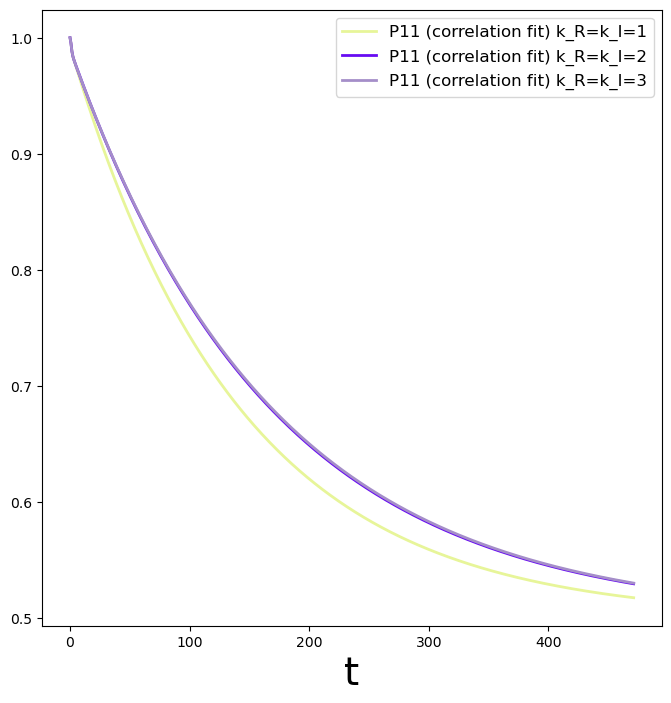

In [39]:
plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (correlation fit) k_R=k_I={pk + 1}",
    )
    for pk, result in enumerate(results_corr_fit_pk)
]);

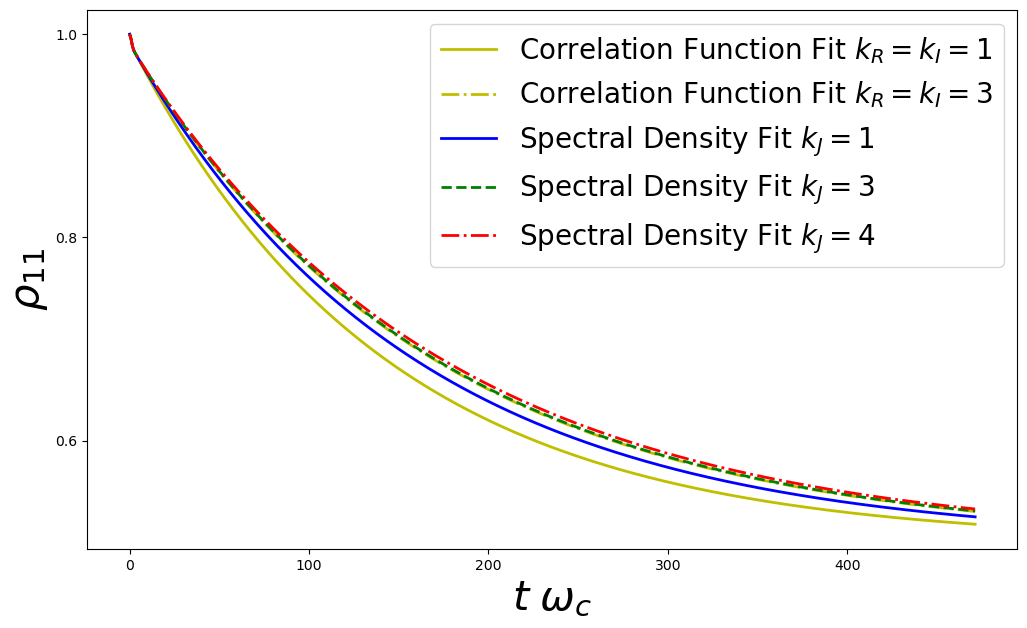

In [40]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations([
    (
        results_corr_fit_pk[0], P11p,
        'y', "Correlation Function Fit $k_R=k_I=1$",
    ),
    (
        results_corr_fit_pk[2], P11p,
        'y-.', "Correlation Function Fit $k_R=k_I=3$",
    ),
    (results_spectral_fit_pk[0], P11p, 'b', "Spectral Density Fit $k_J=1$"),
    (results_spectral_fit_pk[2], P11p, 'g--', "Spectral Density Fit $k_J=3$"),
    (results_spectral_fit_pk[3], P11p, 'r-.', "Spectral Density Fit $k_J=4$"),
], axes=axes)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r'$\rho_{11}$', fontsize=30)
axes.set_xlabel(r'$t\;\omega_c$', fontsize=30)
axes.legend(loc=0, fontsize=20);

## About

In [41]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.0.dev0+afd160b
Numpy Version:      1.22.4
Scipy Version:      1.8.1
Cython Version:     0.29.33
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     2
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/work/qutip-tutorials/qutip-tutorials/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [42]:
assert np.allclose(
    expect(P11p, results_spectral_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)